In [1]:
import geopandas as gpd
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.visualization import ee_viz
from src.data import mtbs
from src.data import shape_processor
from src.data import gedi_pipeline
from src.data import k_nn
import ee
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from fitter import Fitter, get_common_distributions, get_distributions

import importlib
importlib.reload(gedi_pipeline)

2023-06-05 17:00:41,939 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.gedi_pipeline' from '/home/jk871/fire-regen/src/data/gedi_pipeline.py'>

In [12]:
ee.Authenticate()


Successfully saved authorization token.


In [2]:
ee.Initialize()

### Prep the data

In [3]:
sierras = gpd.read_file("../../../data/shapefiles/sierras_convex_hull.shp")

In [4]:
firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2019', '2020', '2021', '2022']).filter_within_geometry(sierras)

In [8]:
burn_severity_2019 = mtbs.get_burn_severity_data_for_year(2019)
burn_severity_2020 = mtbs.get_burn_severity_data_for_year(2020)
burn_severity_2021 = mtbs.get_burn_severity_data_for_year(2021)

In [9]:
gedi_gdf= gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/sierras_matched_lc_all_2x2.csv')
gedi_burned, gedi_unburned = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_gdf)

2023-06-05 17:14:05,278 DEBUG: Excluded shots on the burn boundaries, shots remaining:         9446235 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-05 17:14:05,736 DEBUG: Number of GEDI shots that burned at least once:                  1440937 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-05 17:14:07,310 DEBUG: Number of GEDI shots that never burned since 1984:         7852535 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-05 17:14:07,812 DEBUG: Number of shots that burned exactly once:                    1253729 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-05 17:14:08,069 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    771977 [in exclude_shots_on_burn_b

### Analysis of a single fire - CREEK

In [5]:
creek_fire = sierra_firep.get_fire('CREEK')

In [7]:
creek_fire.cont_date

Timestamp('2020-12-24 00:00:00+0000', tz='UTC')

In [9]:
creek_hull = shape_processor.get_convex_hull(creek_fire.fire.geometry, 4326)

In [23]:
ee_viz.viz_burn_severity(burn_severity_2019, creek_hull.geometry.iloc[0], ['burn_severity', 'burn_year'], legend=False)

Map(center=[40.22379133988073, -121.00067906710973], controls=(WidgetControl(options=['position', 'transparent…

In [92]:
gedi_creek_before = gedi_burned[gedi_burned.absolute_time < creek_fire.alarm_date].sjoin(creek_fire.fire, how="inner", predicate="within")

In [94]:
gedi_creek_after = gedi_burned[gedi_burned.absolute_time > creek_fire.cont_date].sjoin(creek_fire.fire, how="inner", predicate="within")

In [96]:
closest_indeces, distances = k_nn.nearest_neighbors(gedi_creek_before, gedi_creek_after, 1)

In [98]:
gedi_creek_before['closest_index'] = closest_indeces
gedi_creek_before['closest_distance'] = distances

In [113]:
gedi_creek_before['agbd_after'] = gedi_creek_after.iloc[closest_indeces.flatten()].agbd.values

In [193]:
gedi_matches = gedi_creek_before[gedi_creek_before.closest_distance < 10]

In [178]:
gedi_matches.shape[0]

11568

In [194]:
gedi_perfect_matches = gedi_matches[gedi_matches.burn_severity_std==0]
gedi_perfect_matches

shot_number                    absolute_time  lon_lowestmode  \
11851017  43360000200123531 2019-09-18 03:56:51.270057+00:00     -119.225418   
11851039  43360200200123996 2019-09-18 03:56:50.832009+00:00     -119.224149   
11969093  43360600200402919 2019-09-18 03:56:51.278321+00:00     -119.198684   
11995273  88970100200080474 2020-07-08 07:31:31.510944+00:00     -119.258849   
11995275  88970200200085632 2020-07-08 07:31:31.250628+00:00     -119.253950   
...                     ...                              ...             ...   
23430492  87750100200119469 2020-06-30 10:39:47.791854+00:00     -119.210117   
23430493  87750100200119470 2020-06-30 10:39:47.800118+00:00     -119.209620   
27513788  88970000200085353 2020-07-08 07:31:34.647314+00:00     -119.081696   
27555197  43361100200119712 2019-09-18 03:56:52.108908+00:00     -119.157791   
27558818  21831100200228885 2019-05-02 10:57:55.153319+00:00     -119.140173   

          lat_lowestmode        agbd  agbd_pi_lower  agbd_pi_upper    agbd_se  \
11851017       37.197890  305.104645     143.575333     526.803406  11.109265   
11851039       37.184887   43.450420       1.227954     145.811798  11.103634   
11969093       37.179487   62.567810       5.858725     179.546143  11.127700   
11995273       37.210756   49.532108       2.416839     156.780243  11.102520   
11995275       37.207644  105.308418      22.842939     247.890854  11.099579   
...                  ...         ...            ...            ...        ...   
23430492       37.419266  121.663040      30.722145     272.825775  11.118943   
23430493       37.419611  115.468994      27.700975     263.352142  11.099245   
27513788       37.340376   75.747566      10.256437     201.754974  11.173312   
27555197       37.192396   42.359516       1.044097     143.880676  11.115973   
27558818       37.338773  189.142868      68.390808     370.022522  11.101556   

          l2_quality_flag  l4_quality_flag  ...  OBJECTIVE FIRE_NUM  \
11851017                1                1  ...        1.0      NaN   
11851039                1                1  ...        1.0      NaN   
11969093                1                1  ...        1.0      NaN   
11995273                1                1  ...        1.0      NaN   
11995275                1                1  ...        1.0      NaN   
...                   ...              ...  ...        ...      ...   
23430492                1                1  ...        1.0      NaN   
23430493                1                1  ...        1.0      NaN   
27513788                1                1  ...        1.0      NaN   
27555197                1                1  ...        1.0      NaN   
27558818                1                1  ...        1.0      NaN   

           Shape_Length    Shape_Area COMPLEX_NAME COMPLEX_INCNUM  FID  \
11851017  818087.845138  1.537168e+09          NaN            NaN    0   
11851039  818087.845138  1.537168e+09          NaN            NaN    0   
11969093  818087.845138  1.537168e+09          NaN            NaN    0   
11995273  818087.845138  1.537168e+09          NaN            NaN    0   
11995275  818087.845138  1.537168e+09          NaN            NaN    0   
...                 ...           ...          ...            ...  ...   
23430492  818087.845138  1.537168e+09          NaN            NaN    0   
23430493  818087.845138  1.537168e+09          NaN            NaN    0   
27513788  818087.845138  1.537168e+09          NaN            NaN    0   
27555197  818087.845138  1.537168e+09          NaN            NaN    0   
27558818  818087.845138  1.537168e+09          NaN            NaN    0   

          closest_index  closest_distance  agbd_after  
11851017             76          7.650248   58.232662  
11851039           5089          8.332433  147.814270  
11969093            624          5.063272  126.623932  
11995273           8257          3.808112   36.485653  
11995275            784          9.569467   59.248047  
... 

<Axes: xlabel='agbd', ylabel='agbd_after'>

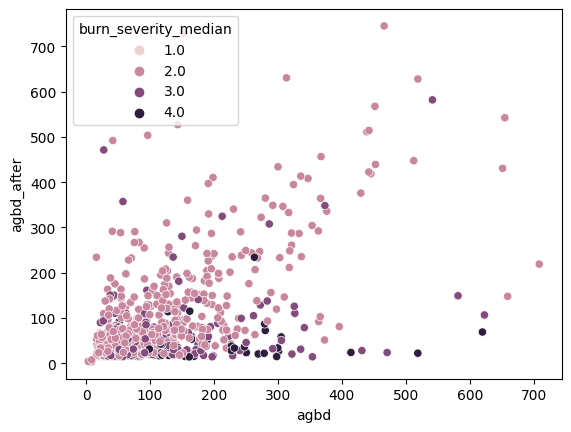

In [152]:
sns.scatterplot(gedi_matches[gedi_matches.burn_severity_std==0], x='agbd', y='agbd_after', hue='burn_severity_median')

In [195]:
gedi_perfect_matches['agbd_diff'] = gedi_perfect_matches.agbd - gedi_perfect_matches.agbd_after

In [196]:
stats.shapiro(gedi_perfect_matches[gedi_perfect_matches.burn_severity_median==2].agbd_diff)

ShapiroResult(statistic=0.8495244383811951, pvalue=2.0845912710680964e-21)

In [182]:
stats.ttest_rel(gedi_perfect_matches[gedi_perfect_matches.burn_severity_median==2].agbd, gedi_perfect_matches[gedi_perfect_matches.burn_severity_median==2].agbd_after)

TtestResult(statistic=9.016092336827384, pvalue=3.1517947363903824e-19, df=3468)

In [183]:
stats.ttest_rel(gedi_perfect_matches[gedi_perfect_matches.burn_severity_median==4].agbd, gedi_perfect_matches[gedi_perfect_matches.burn_severity_median==4].agbd_after)

TtestResult(statistic=35.450104986462236, pvalue=5.008408430044787e-196, df=1374)

In [197]:
stats.wilcoxon(gedi_perfect_matches[gedi_perfect_matches.burn_severity_median==4].agbd, gedi_perfect_matches[gedi_perfect_matches.burn_severity_median==4].agbd_after)

WilcoxonResult(statistic=26.0, pvalue=1.3425025765057958e-10)

In [198]:
stats.wilcoxon(gedi_perfect_matches[gedi_perfect_matches.burn_severity_median==2].agbd, gedi_perfect_matches[gedi_perfect_matches.burn_severity_median==2].agbd_after)

WilcoxonResult(statistic=47416.0, pvalue=3.4532026974431166e-06)

<Axes: xlabel='agbd_diff', ylabel='Count'>

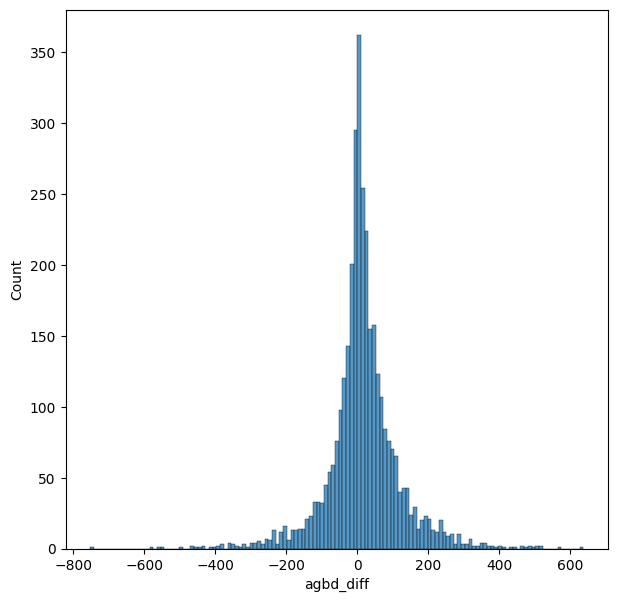

In [187]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.histplot(gedi_perfect_matches[gedi_perfect_matches.burn_severity_median==2], x='agbd_diff', ax=ax)

(0.0, 300.0)

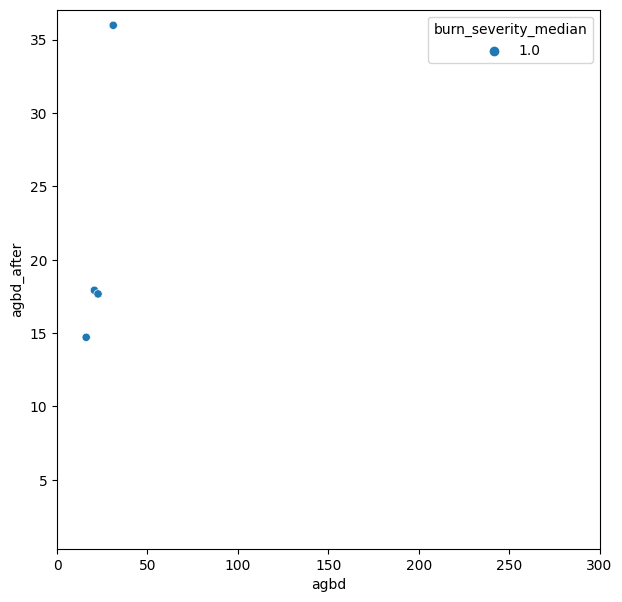

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(gedi_perfect_matches[gedi_perfect_matches.burn_severity_median==1], x='agbd', y='agbd_after', hue='burn_severity_median', ax=ax)
ax.set_ylim((0.300))
ax.set_xlim(0,300)

(0.0, 500.0)

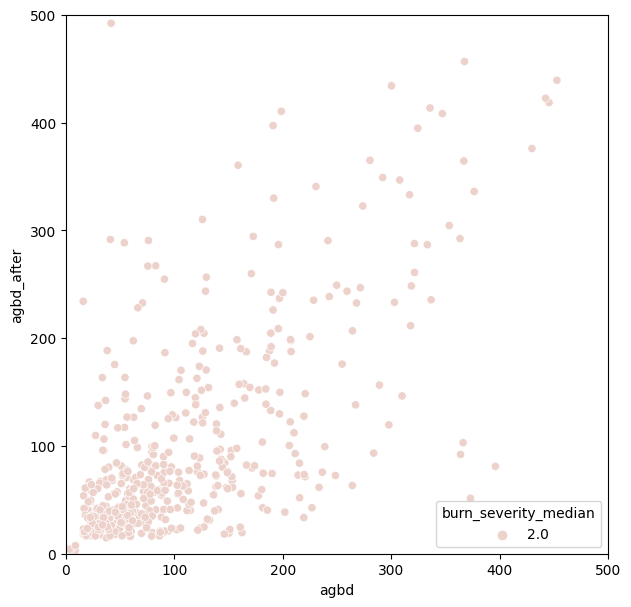

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(gedi_perfect_matches[gedi_perfect_matches.burn_severity_median==2], x='agbd', y='agbd_after', hue='burn_severity_median', ax=ax)
ax.set_ylim((0,500))
ax.set_xlim(0,500)

<Axes: xlabel='agbd', ylabel='Count'>

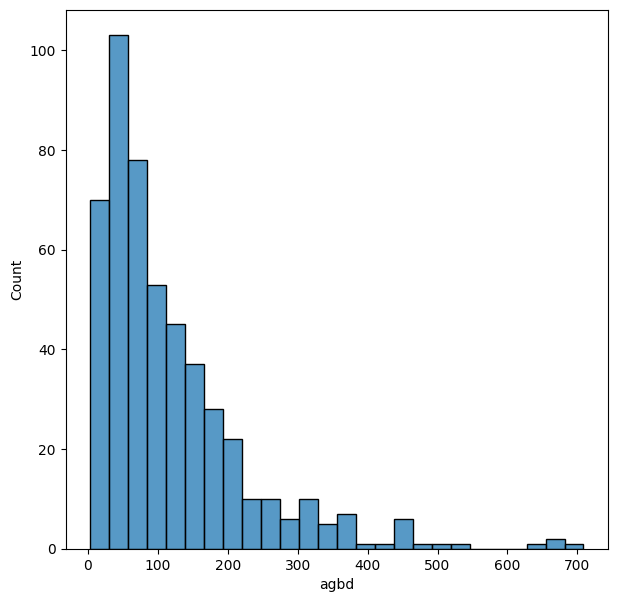

In [161]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.histplot(gedi_perfect_matches[gedi_perfect_matches.burn_severity_median==2], x='agbd', ax=ax)

<Axes: xlabel='agbd_diff'>

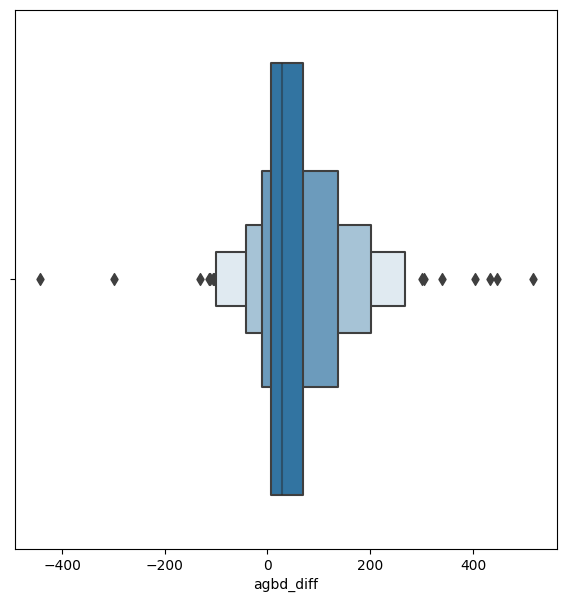

In [202]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.boxenplot(gedi_perfect_matches[gedi_perfect_matches.burn_severity_median==3], x='agbd_diff', ax=ax)

(0.0, 500.0)

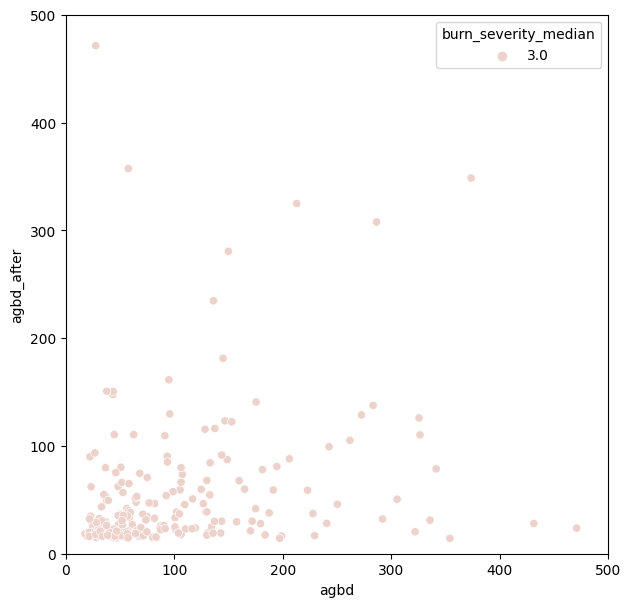

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(gedi_perfect_matches[gedi_perfect_matches.burn_severity_median==3], x='agbd', y='agbd_after', hue='burn_severity_median', ax=ax)
ax.set_ylim((0,500))
ax.set_xlim(0,500)

(0.0, 500.0)

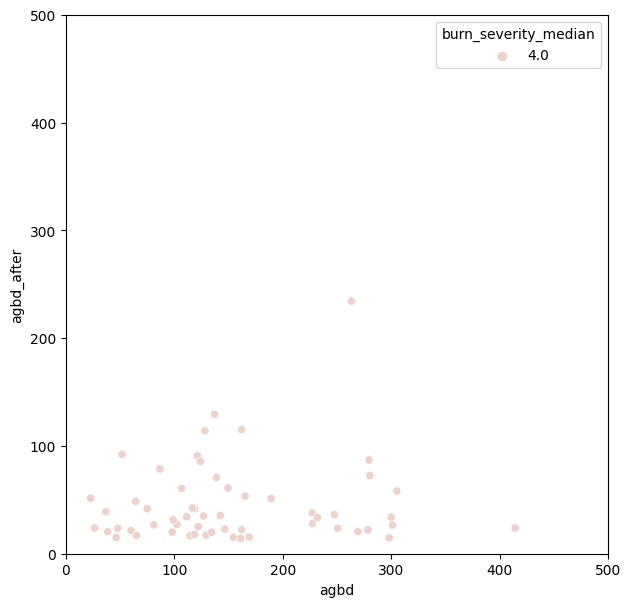

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(gedi_perfect_matches[gedi_perfect_matches.burn_severity_median==4], x='agbd', y='agbd_after', hue='burn_severity_median', ax=ax)
ax.set_ylim((0,500))
ax.set_xlim(0,500)

In [112]:
gedi_creek_after.iloc[closest_indeces.flatten()].agbd.values

array([ 20.96184731,  21.89567947, 140.77740479, ...,  21.13727188,
       210.83119202,  63.30975342])

In [76]:
gedi_creek_before_2[['burn_severity_3x3', 'burn_severity_std']]

burn_severity_3x3  burn_severity_std
9955392          [0 0 0 0]                0.0
10313587         [0 0 0 0]                0.0
24168196         [0 0 0 0]                0.0
24168197         [0 0 0 0]                0.0
24168204         [0 0 0 0]                0.0
...                    ...                ...
27559019         [2 3 2 3]                0.5
27559043         [3 3 3 3]                0.0
27559046         [3 3 3 3]                0.0
27559050         [4 4 4 4]                0.0
27559173         [2 1 2 1]                0.5

[42462 rows x 2 columns]

In [86]:
gedi_creek_before_2[(gedi_creek_before_2.burn_severity_std==0) & (gedi_creek_before_2.burn_year_std==0) & (gedi_creek_before_2.burn_year_mean==2020) & (gedi_creek_before_2.burn_counts_median==1)]

shot_number                    absolute_time  lon_lowestmode  \
11849980  42640500300289713 2019-09-13 12:53:31.056613+00:00     -119.227291   
11849983  42640500300289721 2019-09-13 12:53:31.122725+00:00     -119.223405   
11849986  42640500300289729 2019-09-13 12:53:31.188837+00:00     -119.219534   
11849994  42640600300524277 2019-09-13 12:53:31.002897+00:00     -119.231811   
11849998  42640600300524284 2019-09-13 12:53:31.060745+00:00     -119.228414   
...                     ...                              ...             ...   
27558833  55110000200123661 2019-12-02 21:56:56.763000+00:00     -119.147345   
27558836  55110000200123666 2019-12-02 21:56:56.804323+00:00     -119.144929   
27559043  55110500200120017 2019-12-02 21:56:56.957207+00:00     -119.116625   
27559046  55110500200120020 2019-12-02 21:56:56.981999+00:00     -119.115152   
27559050  55110500200120026 2019-12-02 21:56:57.031583+00:00     -119.112201   

          lat_lowestmode        agbd  agbd_pi_lower  agbd_pi_upper    agbd_se  \
11849980       37.148174   41.202484       0.870942     141.719238  11.112186   
11849983       37.145481  272.180328     121.303764     483.207306  11.105767   
11849986       37.142818   18.178072   -9999.000000      95.038727  11.110293   
11849994       37.144141  168.818085      56.404099     341.352814  11.100285   
11849998       37.141786  447.472992     245.180283     710.162781  11.151317   
...                  ...         ...            ...            ...        ...   
27558833       37.339037   50.680721       2.674287     158.829422  11.104253   
27558836       37.340694   30.573559       0.002050     121.294968  11.105664   
27559043       37.330528   90.310677      16.162523     224.583832  11.101069   
27559046       37.331549   56.771923       4.205933     169.483734  11.104912   
27559050       37.333593   56.514225       4.138298     169.023590  11.102629   

          l2_quality_flag  l4_quality_flag  ...  REPORT_AC     GIS_ACRES  \
11849980                1                1  ...   379895.0  379842.40625   
11849983                1                1  ...   379895.0  379842.40625   
11849986                1                1  ...   379895.0  379842.40625   
11849994                1                1  ...   379895.0  379842.40625   
11849998                1                1  ...   379895.0  379842.40625   
...                   ...              ...  ...        ...           ...   
27558833                1                1  ...   379895.0  379842.40625   
27558836                1                1  ...   379895.0  379842.40625   
27559043                1                1  ...   379895.0  379842.40625   
27559046                1                1  ...   379895.0  379842.40625   
27559050                1                1  ...   379895.0  379842.40625   

          C_METHOD  OBJECTIVE FIRE_NUM   Shape_Length    Shape_Area  \
11849980       8.0        1.0      NaN  818087.845138  1.537168e+09   
11849983       8.0        1.0      NaN  818087.845138  1.537168e+09   
11849986       8.0        1.0      NaN  818087.845138  1.537168e+09   
11849994       8.0        1.0      NaN  818087.845138  1.537168e+09   
11849998       8.0        1.0      NaN  818087.845138  1.537168e+09   
...            ...        ...      ...            ...           ...   
27558833       8.0        1.0      NaN  818087.845138  1.537168e+09   
27558836       8.0        1.0      NaN  818087.845138  1.537168e+09   
27559043       8.0        1.0      NaN  818087.845138  1.537168e+09   
27559046       8.0        1.0      NaN  818087.845138  1.537168e+09   
27559050       8.0        1.0      NaN  818087.845138  1.537168e+09   

          COMPLEX_NAME  COMPLEX_INCNUM FID  
11849980           NaN             NaN   0  
11849983           NaN             NaN   0  
11849986           NaN             NaN   0  
11849994           NaN             NaN   0  
11849998           NaN             NaN   0  
...                ...             ...  ..  
2

In [64]:
creek_fire.fire.columns

Index(['YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM',
       'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'COMMENTS', 'REPORT_AC',
       'GIS_ACRES', 'C_METHOD', 'OBJECTIVE', 'FIRE_NUM', 'Shape_Length',
       'Shape_Area', 'COMPLEX_NAME', 'COMPLEX_INCNUM', 'geometry',
       'index_right', 'FID'],
      dtype='object')

<Axes: >

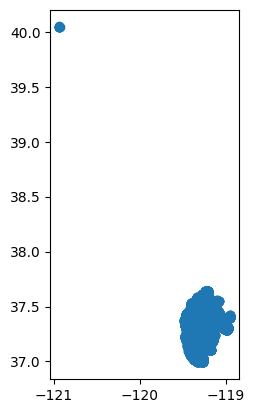

In [87]:
gedi_creek_before_2.plot()

### Figure out a control distance for GEDI shots

In [340]:
gedi_unburned_2019 = gedi_unburned[gedi_unburned.gedi_year == 2019]
gedi_unburned_2020 = gedi_unburned[gedi_unburned.gedi_year == 2020]
gedi_unburned_2021 = gedi_unburned[gedi_unburned.gedi_year == 2021]
gedi_unburned_2022 = gedi_unburned[gedi_unburned.gedi_year == 2022]

(0.0, 700.0)

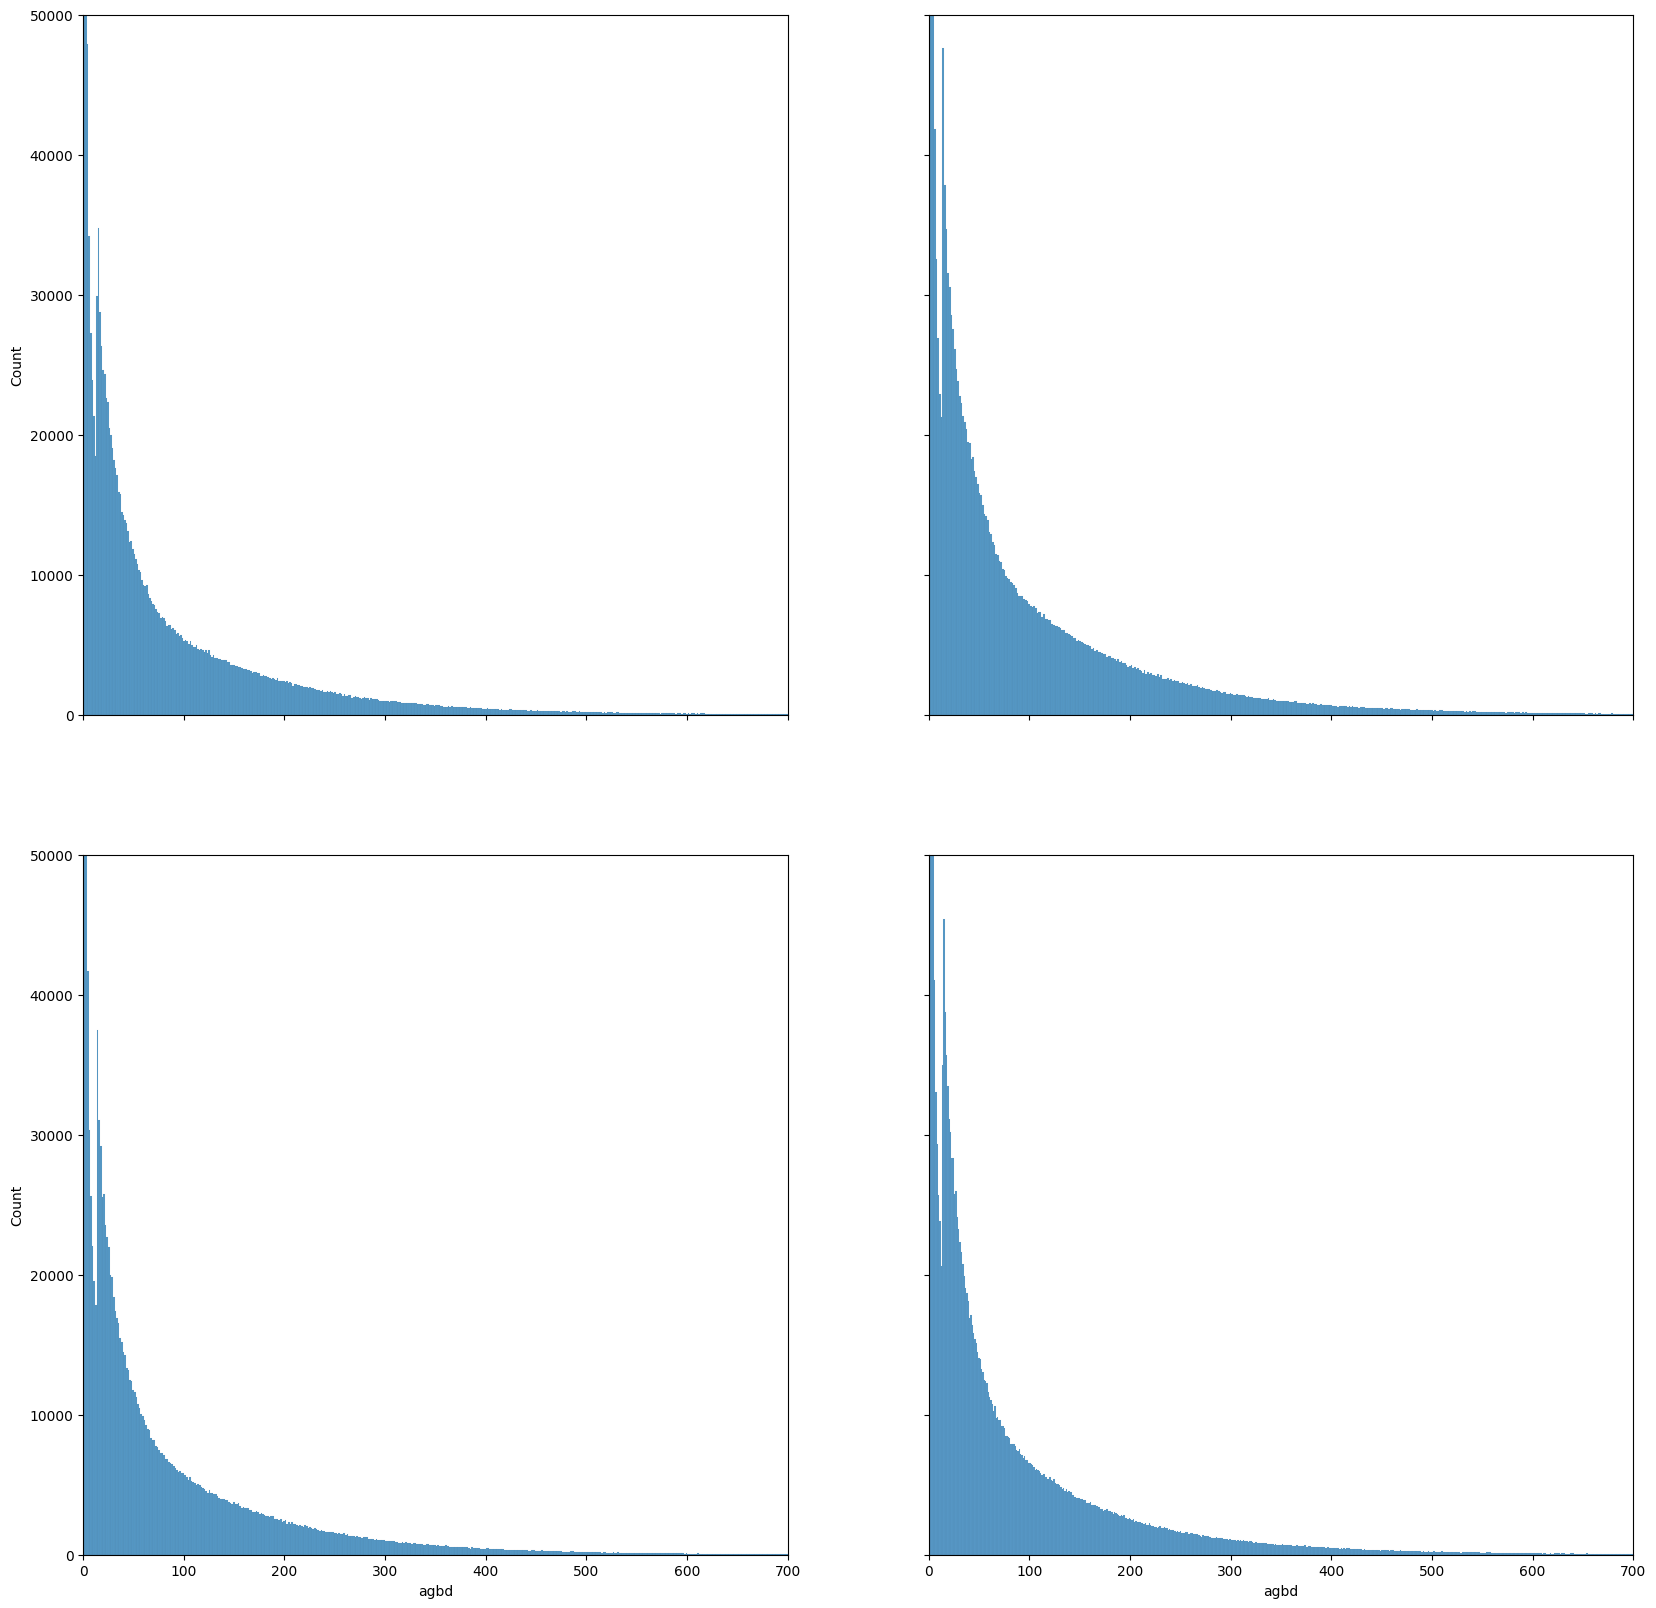

In [341]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20), sharex=True, sharey=True)
sns.histplot(gedi_unburned_2019, x='agbd', ax=ax[0][0])
sns.histplot(gedi_unburned_2020, x='agbd', ax=ax[0][1])
sns.histplot(gedi_unburned_2021, x='agbd', ax=ax[1][0])
sns.histplot(gedi_unburned_2022, x='agbd', ax=ax[1][1])
ax[0][0].set_ylim((0, 50000))
ax[0][0].set_xlim((0, 700))

In [86]:
def find_matches(left, right, column):
    closest_indeces, distances = k_nn.nearest_neighbors(left, right, 1)

    result = left.copy()
    result[f'{column}_after'] = right.iloc[closest_indeces.flatten()][column].values
    result['closest_distance'] = distances
    result[f'{column}_diff'] = result[column] - result[f'{column}_after']
    return result

In [342]:
compare_2019_to_2020 = find_matches(gedi_unburned_2019, gedi_unburned_2020, 'agbd')
compare_2020_to_2021 = find_matches(gedi_unburned_2020, gedi_unburned_2021, 'agbd')
compare_2021_to_2022 = find_matches(gedi_unburned_2021, gedi_unburned_2022, 'agbd')

In [343]:
compare_all = find_matches(pd.concat([gedi_unburned_2019, gedi_unburned_2020]), pd.concat([gedi_unburned_2021, gedi_unburned_2022]), 'agbd')

In [89]:
compare_2019_to_2020 = compare_2019_to_2020[(compare_2019_to_2020.land_cover_std == 0) & (compare_2019_to_2020.land_cover_mean == 1) & (compare_2019_to_2020.pft_class == 1)]
compare_2020_to_2021 = compare_2020_to_2021[(compare_2020_to_2021.land_cover_std == 0) & (compare_2020_to_2021.land_cover_mean == 1) & (compare_2020_to_2021.pft_class==1)]
compare_2021_to_2022 = compare_2021_to_2022[(compare_2021_to_2022.land_cover_std == 0) & (compare_2021_to_2022.land_cover_mean == 1) & (compare_2021_to_2022.pft_class==1)]

In [267]:
compare_all = compare_all[(compare_all.land_cover_std == 0) & (compare_all.land_cover_mean == 1)]

In [90]:
def get_closest_matches(df, distance):
    return df[df.closest_distance < distance]

(0.0, 1000.0)

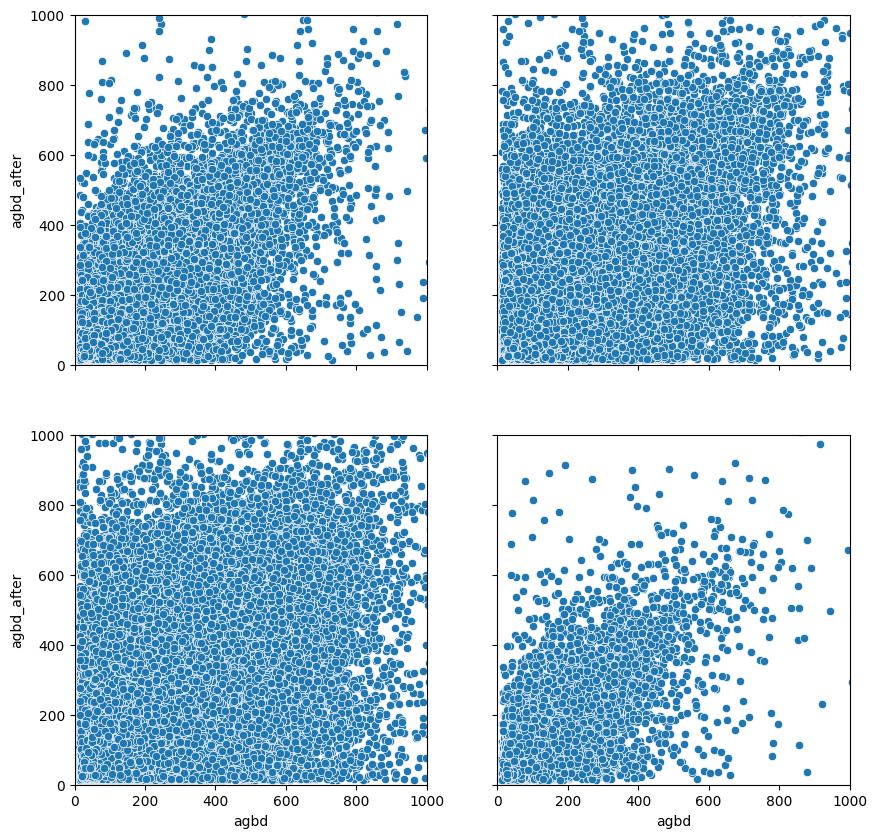

In [137]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
sns.scatterplot(get_closest_matches(compare_all, 10), x='agbd', y='agbd_after', ax=ax[0][0])
sns.scatterplot(get_closest_matches(compare_all, 20), x='agbd', y='agbd_after', ax=ax[0][1])
sns.scatterplot(get_closest_matches(compare_all, 30), x='agbd', y='agbd_after', ax=ax[1][0])
sns.scatterplot(get_closest_matches(compare_all, 5), x='agbd', y='agbd_after', ax=ax[1][1])
ax[0][0].set_ylim((0,1000))
ax[0][0].set_xlim(0,1000)

(0.0, 1000.0)

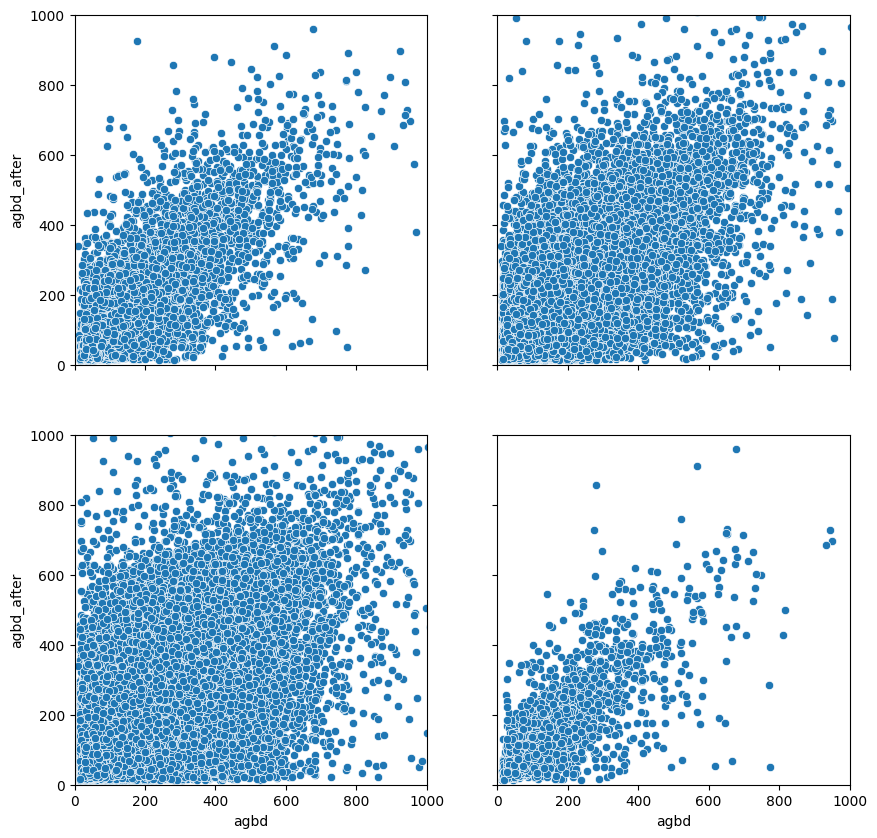

In [111]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
sns.scatterplot(get_closest_matches(compare_2019_to_2020, 10), x='agbd', y='agbd_after', ax=ax[0][0])
sns.scatterplot(get_closest_matches(compare_2019_to_2020, 20), x='agbd', y='agbd_after', ax=ax[0][1])
sns.scatterplot(get_closest_matches(compare_2019_to_2020, 30), x='agbd', y='agbd_after', ax=ax[1][0])
sns.scatterplot(get_closest_matches(compare_2019_to_2020, 5), x='agbd', y='agbd_after', ax=ax[1][1])
ax[0][0].set_ylim((0,1000))
ax[0][0].set_xlim(0,1000)

(0.0, 1000.0)

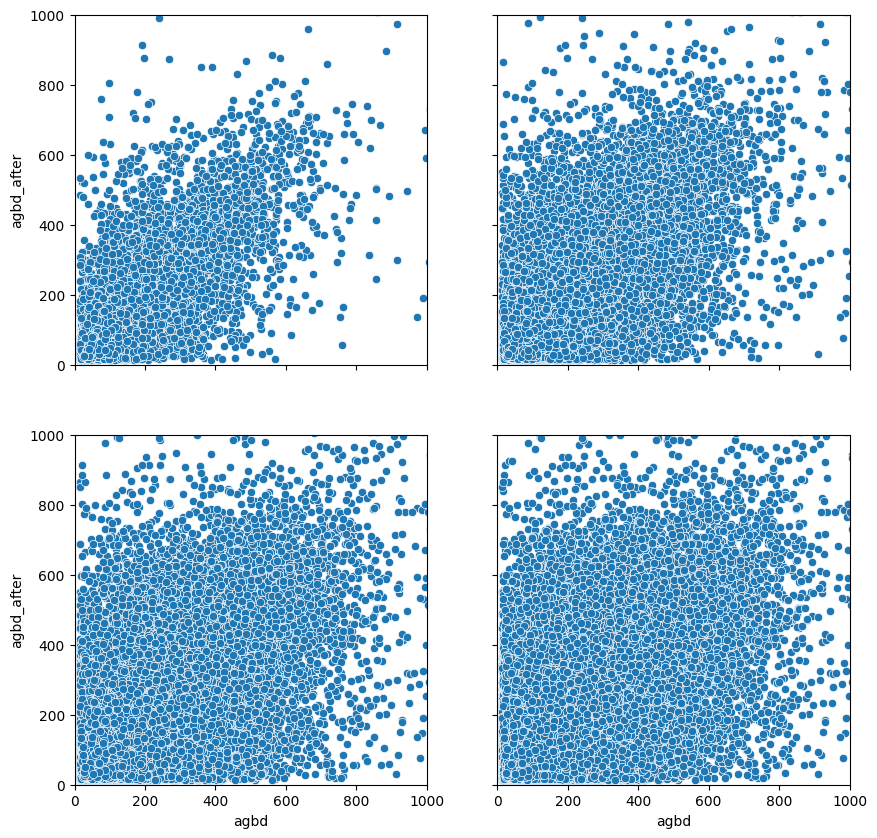

In [80]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
sns.scatterplot(get_closest_matches(compare_2020_to_2021, 10), x='agbd', y='agbd_after', ax=ax[0][0])
sns.scatterplot(get_closest_matches(compare_2020_to_2021, 20), x='agbd', y='agbd_after', ax=ax[0][1])
sns.scatterplot(get_closest_matches(compare_2020_to_2021, 30), x='agbd', y='agbd_after', ax=ax[1][0])
sns.scatterplot(get_closest_matches(compare_2020_to_2021, 40), x='agbd', y='agbd_after', ax=ax[1][1])
ax[0][0].set_ylim((0,1000))
ax[0][0].set_xlim(0,1000)

(0.0, 2000.0)

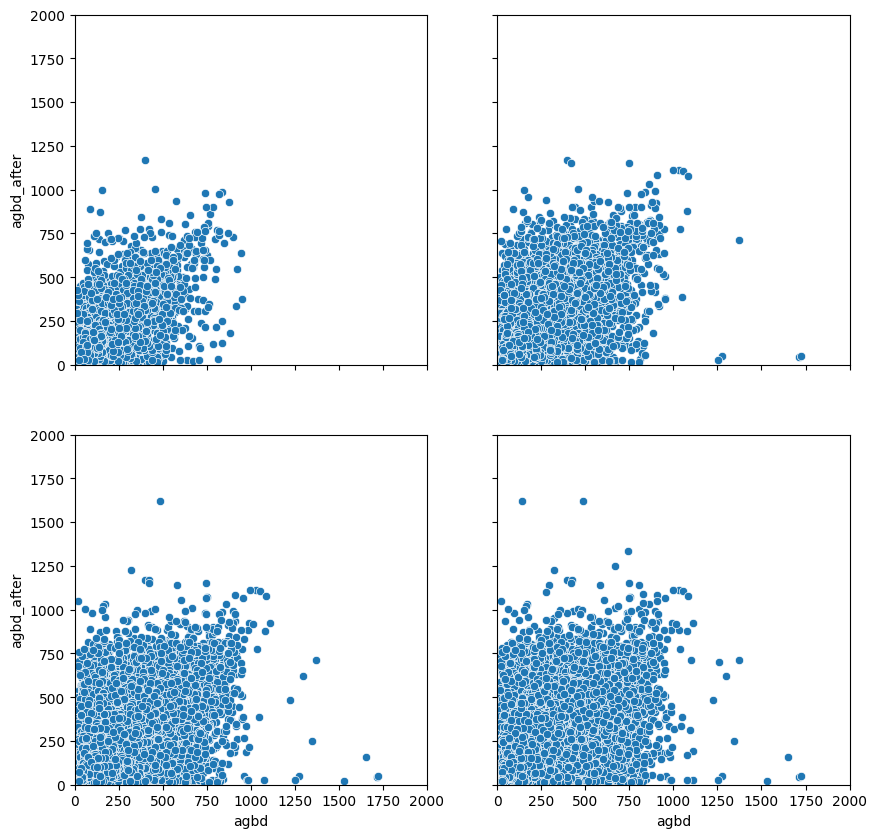

In [83]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
sns.scatterplot(get_closest_matches(compare_2021_to_2022, 10), x='agbd', y='agbd_after', ax=ax[0][0])
sns.scatterplot(get_closest_matches(compare_2021_to_2022, 20), x='agbd', y='agbd_after', ax=ax[0][1])
sns.scatterplot(get_closest_matches(compare_2021_to_2022, 30), x='agbd', y='agbd_after', ax=ax[1][0])
sns.scatterplot(get_closest_matches(compare_2021_to_2022, 40), x='agbd', y='agbd_after', ax=ax[1][1])
ax[0][0].set_ylim((0,2000))
ax[0][0].set_xlim(0,2000)

<Axes: xlabel='agbd_diff', ylabel='Count'>

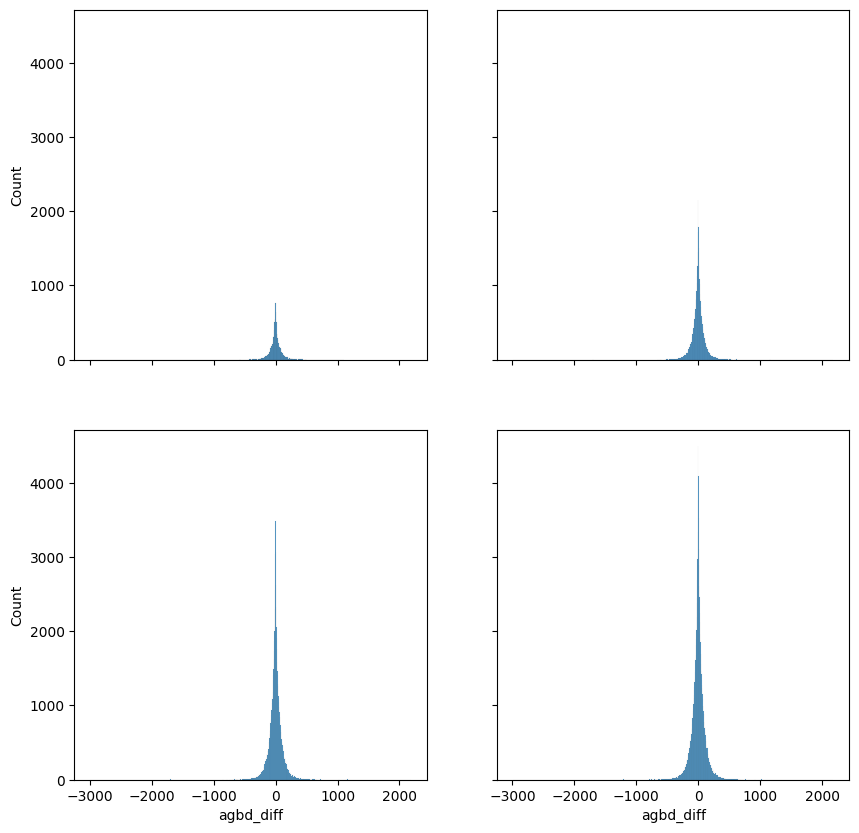

In [93]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
sns.histplot(get_closest_matches(compare_2019_to_2020, 10), x='agbd_diff', ax=ax[0][0])
sns.histplot(get_closest_matches(compare_2019_to_2020, 20), x='agbd_diff', ax=ax[0][1])
sns.histplot(get_closest_matches(compare_2019_to_2020, 30), x='agbd_diff', ax=ax[1][0])
sns.histplot(get_closest_matches(compare_2019_to_2020, 40), x='agbd_diff', ax=ax[1][1])

Best Linear regression coefficient is [0.66272358]. R squared is: 0.43936883205182076.
The error for coeff = 1 is: 0.3243959854038073.


KeyboardInterrupt: 

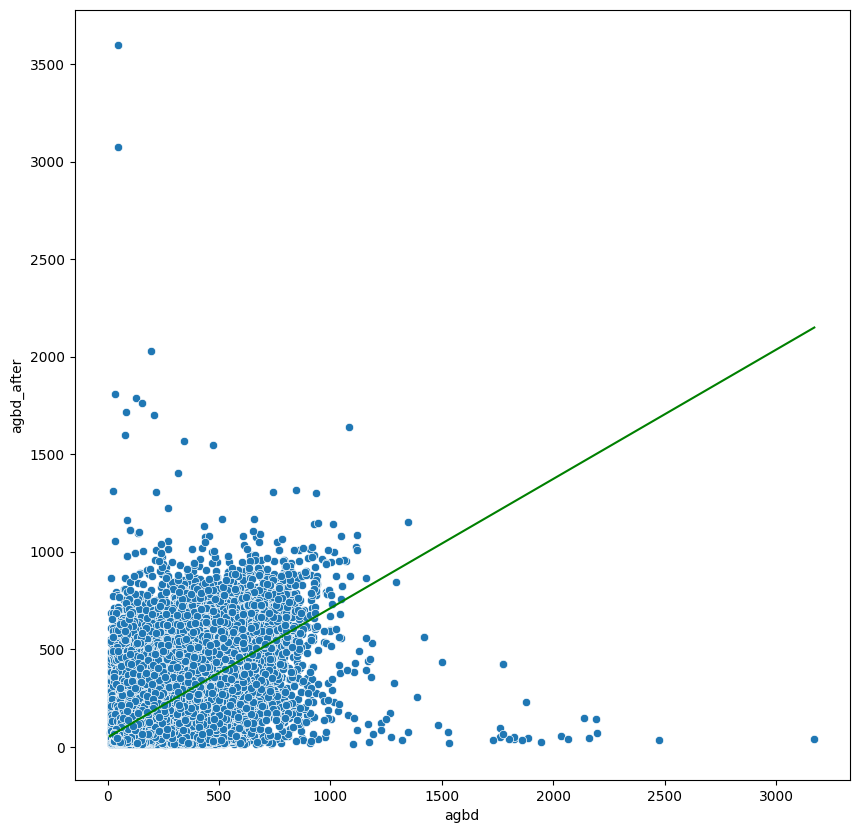

In [268]:
dist_10 = get_closest_matches(compare_all, 20)
reg_10 = LinearRegression().fit(np.reshape(dist_10.agbd.values, (dist_10.shape[0], 1)), dist_10.agbd_after.values)
score = reg_10.score(np.reshape(dist_10.agbd.values, (dist_10.shape[0], 1)), dist_10.agbd_after.values)
print(f'Best Linear regression coefficient is {reg_10.coef_}. R squared is: {score}.')

print(f'The error for coeff = 1 is: {r2_score(dist_10.agbd.values, dist_10.agbd_after.values)}.')

fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
sns.scatterplot(dist_10, x='agbd', y='agbd_after', ax=ax)
sns.lineplot(x=dist_10.agbd.values, y=reg_10.predict(np.reshape(dist_10.agbd.values, (dist_10.shape[0], 1))), color='green')
sns.lineplot(x=dist_10.agbd.values, y=dist_10.agbd.values, color='red')
ax.set_xlim((0, 1000))
ax.set_ylim((0, 1000))

## 3 Ways of analysing fit

### Part 1 - linear regression fit on before and after

In [119]:
def calculate_error_for_distances(df, distance_range, column_x, column_y):
    all_r2 = []
    all_num_matches = []
    for distance in distance_range:
        matches = get_closest_matches(df, distance)
        if (matches.shape[0] == 0):
            all_r2.append(None)
            all_num_matches.append(0)
        else:
            all_r2.append(r2_score(matches[column_x], matches[column_y]))
            all_num_matches.append(matches.shape[0])

    return all_r2, all_num_matches

<Axes: >

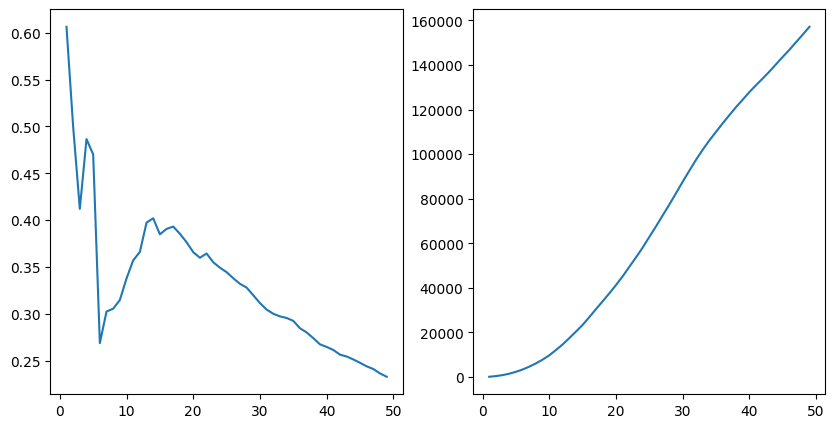

In [128]:
distances = range(1, 50)
r2s, num_matches = calculate_error_for_distances(compare_2019_to_2020, distances, 'agbd', 'agbd_after')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=distances, y=r2s, ax=ax[0])
sns.lineplot(x=distances, y=num_matches, ax=ax[1])

<Axes: >

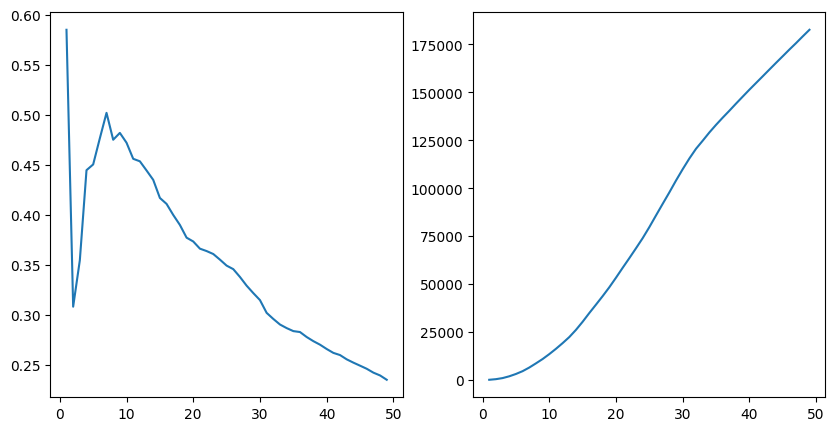

In [129]:
distances = range(1, 50)
r2s, num_matches = calculate_error_for_distances(compare_2020_to_2021, distances, 'agbd', 'agbd_after')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=distances, y=r2s, ax=ax[0])
sns.lineplot(x=distances, y=num_matches, ax=ax[1])

<Axes: >

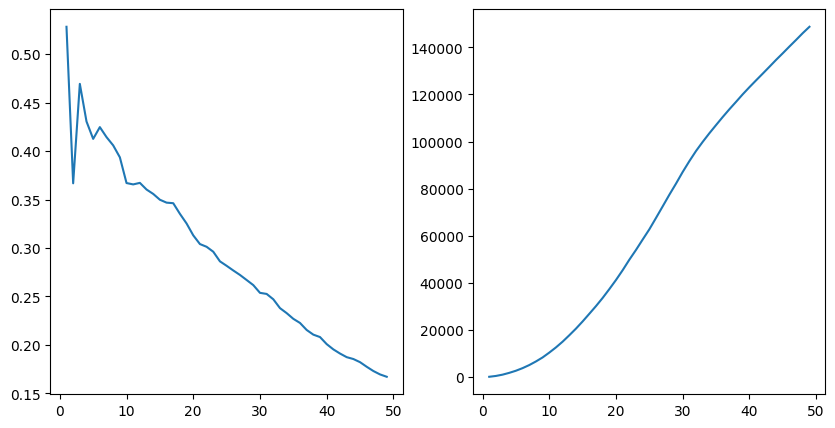

In [130]:
distances = range(1, 50)
r2s, num_matches = calculate_error_for_distances(compare_2021_to_2022, distances, 'agbd', 'agbd_after')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=distances, y=r2s, ax=ax[0])
sns.lineplot(x=distances, y=num_matches, ax=ax[1])

<Axes: >

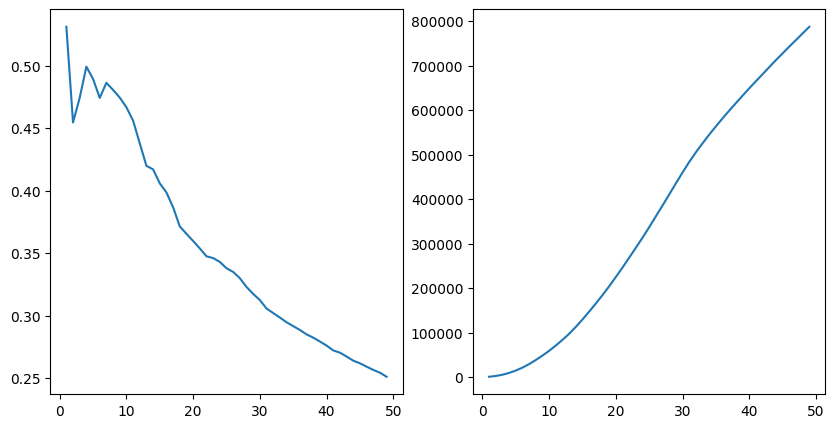

In [138]:
distances = range(1, 50)
r2s, num_matches = calculate_error_for_distances(compare_all, distances, 'agbd', 'agbd_after')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=distances, y=r2s, ax=ax[0])
sns.lineplot(x=distances, y=num_matches, ax=ax[1])

In [ ]:
compare_2019_to_2020 = find_matches(gedi_unburned_2019, gedi_unburned_2020, 'agbd')

In [97]:
dist_10 = get_closest_matches(compare_2019_to_2020, 10)
reg_10 = LinearRegression().fit(np.reshape(dist_10.agbd.values, (dist_10.shape[0], 1)), dist_10.agbd_after.values)

In [98]:
reg_10.score(np.reshape(dist_10.agbd.values, (dist_10.shape[0], 1)), dist_10.agbd_after.values)

0.48066115860835634

In [99]:
reg_10.coef_

array([0.74235029])

(0.0, 1000.0)

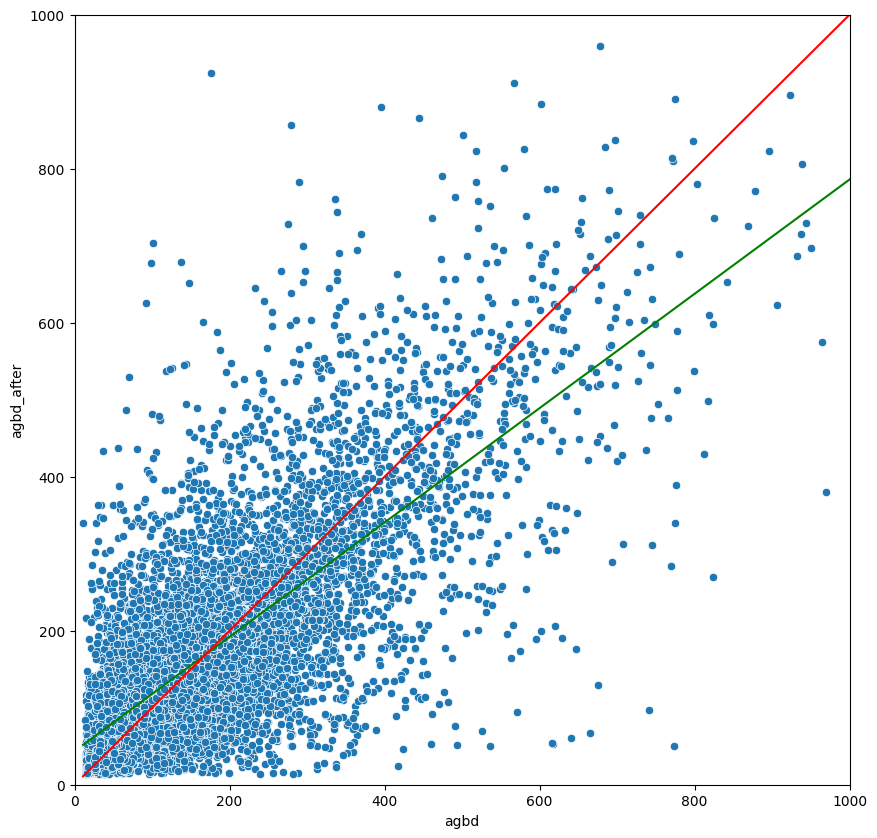

In [103]:
dist_10 = get_closest_matches(compare_2019_to_2020, 10)
reg_10 = LinearRegression().fit(np.reshape(dist_10.agbd.values, (dist_10.shape[0], 1)), dist_10.agbd_after.values)
score = reg_10.score(np.reshape(dist_10.agbd.values, (dist_10.shape[0], 1)), dist_10.agbd_after.values)
print(f'Best Linear regression coefficient is {reg_10.coef_}. R squared is: {score}.')

print(f'The error for coeff = 1 is: {r2_score(dist_10.agbd.values, dist_10.agbd_after.values)}.')

fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
sns.scatterplot(get_closest_matches(compare_2019_to_2020, 10), x='agbd', y='agbd_after', ax=ax)
sns.lineplot(x=dist_10.agbd.values, y=reg_10.predict(np.reshape(dist_10.agbd.values, (dist_10.shape[0], 1))), color='green')
sns.lineplot(x=dist_10.agbd.values, y=dist_10.agbd.values, color='red')
ax.set_xlim((0, 1000))
ax.set_ylim((0, 1000))

### Part 2 - best distribution fit for agbd_diff

Fitting 5 distributions: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


sumsquare_error           aic           bic  kl_div  ks_statistic  \
lognorm         0.000052  1.117665e+04 -1.229881e+06     inf      0.118884   
beta            0.000052  1.097633e+04 -1.229760e+06     inf      0.120499   
norm            0.000052  1.095010e+04 -1.229772e+06     inf      0.120329   
gamma           0.000071           inf -1.210804e+06     inf      0.164402   
burr            0.000199  2.008213e+03 -1.150197e+06     inf      0.693070   

         ks_pvalue  
lognorm        0.0  
beta           0.0  
norm           0.0  
gamma          0.0  
burr           0.0

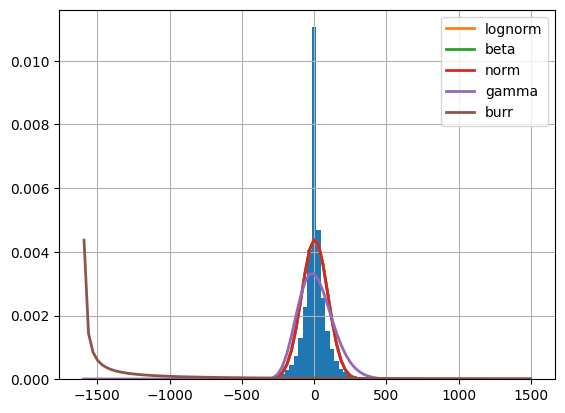

In [140]:
f = Fitter(get_closest_matches(compare_all, 10).agbd_diff.values,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])

f.fit()
f.summary()

In [144]:
# Fit normal
f = Fitter(get_closest_matches(compare_all, 10).agbd_diff.values,
           distributions=["norm"])

f.fit()
#f.summary()
f.get_best(method = 'sumsquare_error')

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 27.20it/s]


{'norm': {'loc': 4.286791167141404, 'scale': 90.86669954319}}

In [145]:
# Fit normal
f = Fitter(get_closest_matches(compare_all, 20).agbd_diff.values,
           distributions=["norm"])

f.fit()
#f.summary()
f.get_best(method = 'sumsquare_error')

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


{'norm': {'loc': 3.6300833833860824, 'scale': 100.9918660280557}}

In [150]:
# Fit normal
f = Fitter(get_closest_matches(compare_all, 5).agbd_diff.values,
           distributions=["norm"])

f.fit()
#f.summary()
f.get_best(method = 'sumsquare_error')

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 15.45it/s]


{'norm': {'loc': 5.334136333625132, 'scale': 87.36450847232194}}

### Part 3 - Tests for being centered around the mean?

In [152]:
# Test # 1 - distribution was drawn from a normal distribution
stats.shapiro(get_closest_matches(compare_all, 5).agbd_diff)

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8519590497016907, pvalue=0.0)

In [153]:
'''
Examples for use are scores of the same set of student in different exams, or repeated sampling from the same units. 
The test measures whether the average score differs significantly across samples (e.g. exams). 
If we observe a large p-value, for example greater than 0.05 or 0.1 then we cannot reject the null hypothesis of identical average scores. 
If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages. 
Small p-values are associated with large t-statistics.
'''
stats.ttest_rel(get_closest_matches(compare_all, 5).agbd, get_closest_matches(compare_all, 5).agbd_after)

TtestResult(statistic=7.373140530767779, pvalue=1.7561745621444e-13, df=14583)

Because of the large number of samples, we get a rejection of the null hypothesis of equal averages even for the control. We can try to do the test on smaller time differences and see if that makes a difference.

In [155]:
stats.wilcoxon(get_closest_matches(compare_all, 5).agbd, get_closest_matches(compare_all, 5).agbd_after)

WilcoxonResult(statistic=48812114.5, pvalue=1.1522004456438105e-17)

### Seasonal test - comparing just summers from one year to the other

In [156]:
gedi_unburned_2019 = gedi_unburned[gedi_unburned.gedi_year == 2019]
gedi_unburned_2020 = gedi_unburned[gedi_unburned.gedi_year == 2020]
gedi_unburned_2021 = gedi_unburned[gedi_unburned.gedi_year == 2021]
gedi_unburned_2022 = gedi_unburned[gedi_unburned.gedi_year == 2022]

In [158]:
gedi_unburned_2019 = gedi_unburned_2019[gedi_unburned_2019.gedi_month.isin([5, 6, 7, 8, 9])]
gedi_unburned_2020 = gedi_unburned_2020[gedi_unburned_2020.gedi_month.isin([5, 6, 7, 8, 9])]
gedi_unburned_2021 = gedi_unburned_2021[gedi_unburned_2021.gedi_month.isin([5, 6, 7, 8, 9])]
gedi_unburned_2022 = gedi_unburned_2022[gedi_unburned_2022.gedi_month.isin([5, 6, 7, 8, 9])]

In [159]:
compare_2019_to_2020 = find_matches(gedi_unburned_2019, gedi_unburned_2020, 'agbd')
compare_2020_to_2021 = find_matches(gedi_unburned_2020, gedi_unburned_2021, 'agbd')
compare_2021_to_2022 = find_matches(gedi_unburned_2021, gedi_unburned_2022, 'agbd')

In [166]:
compare_all = find_matches(pd.concat([gedi_unburned_2019, gedi_unburned_2020]), pd.concat([gedi_unburned_2021, gedi_unburned_2022]), 'agbd')

In [167]:
compare_all = compare_all[(compare_all.land_cover_std == 0) & (compare_all.land_cover_mean == 1)]

In [160]:
compare_2019_to_2020 = compare_2019_to_2020[(compare_2019_to_2020.land_cover_std == 0) & (compare_2019_to_2020.land_cover_mean == 1)]
compare_2020_to_2021 = compare_2020_to_2021[(compare_2020_to_2021.land_cover_std == 0) & (compare_2020_to_2021.land_cover_mean == 1)]
compare_2021_to_2022 = compare_2021_to_2022[(compare_2021_to_2022.land_cover_std == 0) & (compare_2021_to_2022.land_cover_mean == 1)]

(0.0, 1000.0)

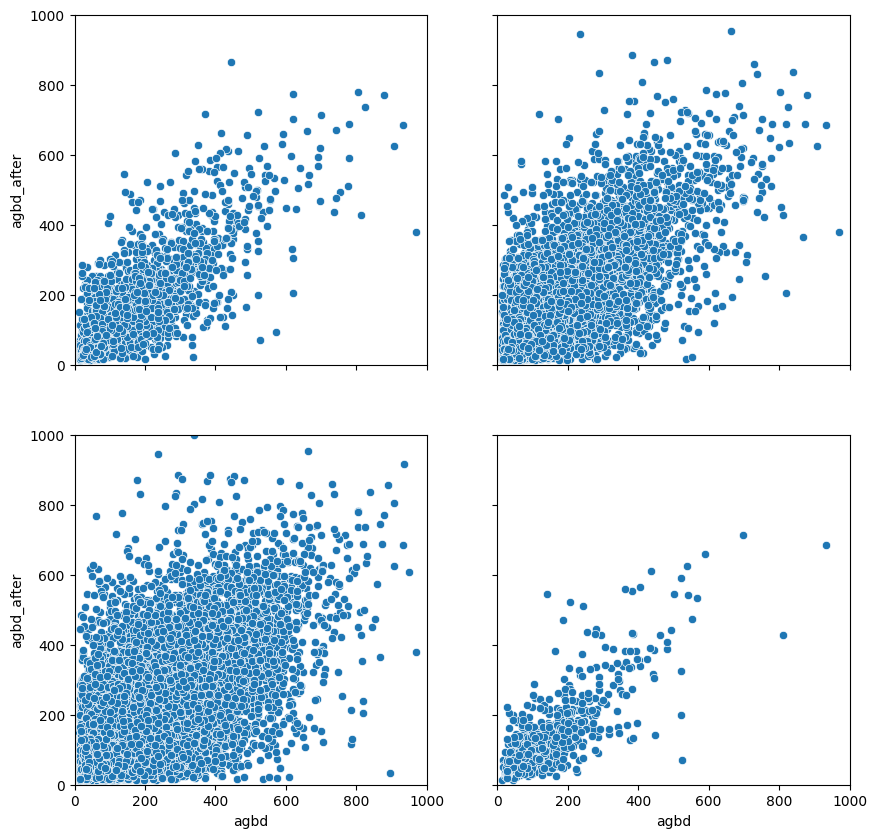

In [162]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
sns.scatterplot(get_closest_matches(compare_2019_to_2020, 10), x='agbd', y='agbd_after', ax=ax[0][0])
sns.scatterplot(get_closest_matches(compare_2019_to_2020, 20), x='agbd', y='agbd_after', ax=ax[0][1])
sns.scatterplot(get_closest_matches(compare_2019_to_2020, 30), x='agbd', y='agbd_after', ax=ax[1][0])
sns.scatterplot(get_closest_matches(compare_2019_to_2020, 5), x='agbd', y='agbd_after', ax=ax[1][1])
ax[0][0].set_ylim((0,1000))
ax[0][0].set_xlim(0,1000)

(0.0, 1000.0)

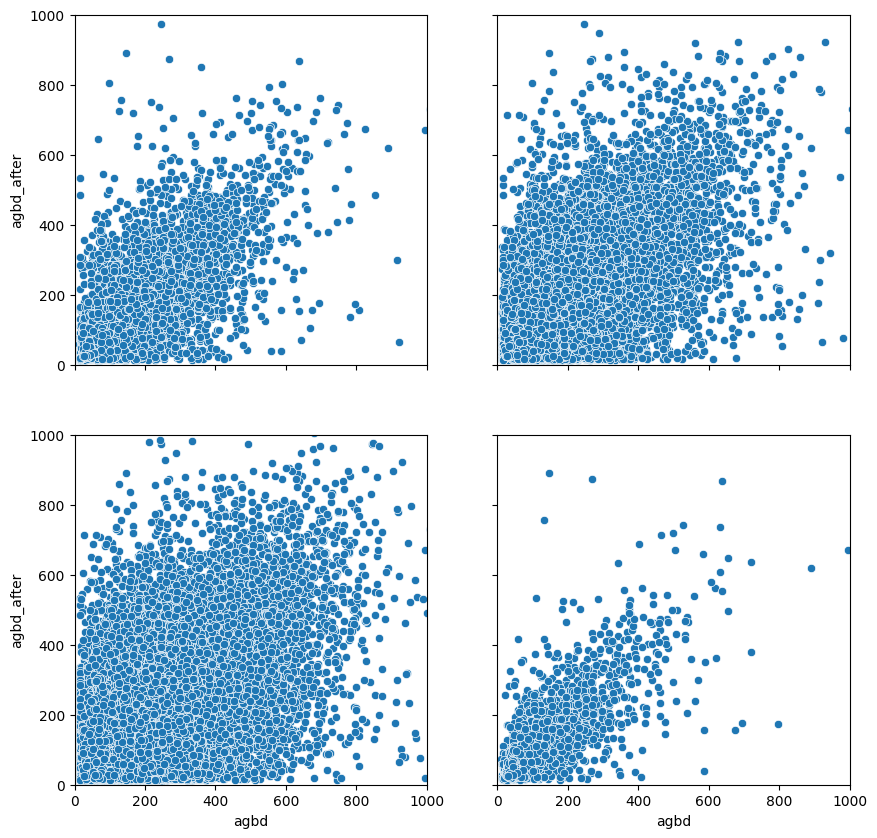

In [168]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
sns.scatterplot(get_closest_matches(compare_all, 10), x='agbd', y='agbd_after', ax=ax[0][0])
sns.scatterplot(get_closest_matches(compare_all, 20), x='agbd', y='agbd_after', ax=ax[0][1])
sns.scatterplot(get_closest_matches(compare_all, 30), x='agbd', y='agbd_after', ax=ax[1][0])
sns.scatterplot(get_closest_matches(compare_all, 5), x='agbd', y='agbd_after', ax=ax[1][1])
ax[0][0].set_ylim((0,1000))
ax[0][0].set_xlim(0,1000)

<Axes: >

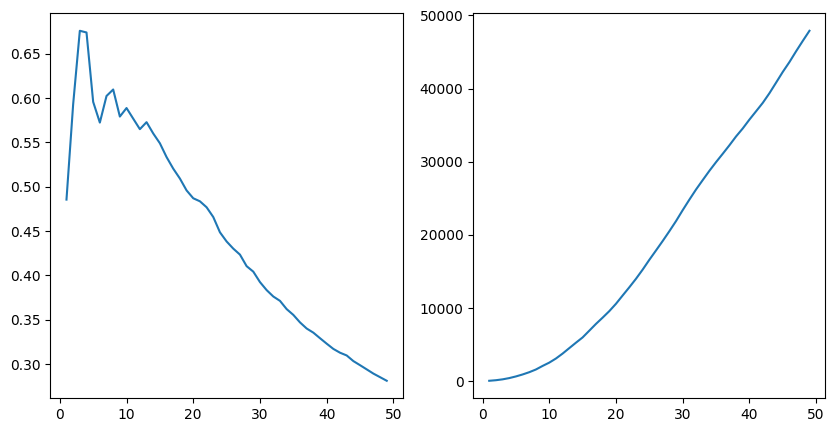

In [163]:
distances = range(1, 50)
r2s, num_matches = calculate_error_for_distances(compare_2019_to_2020, distances, 'agbd', 'agbd_after')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=distances, y=r2s, ax=ax[0])
sns.lineplot(x=distances, y=num_matches, ax=ax[1])

<Axes: >

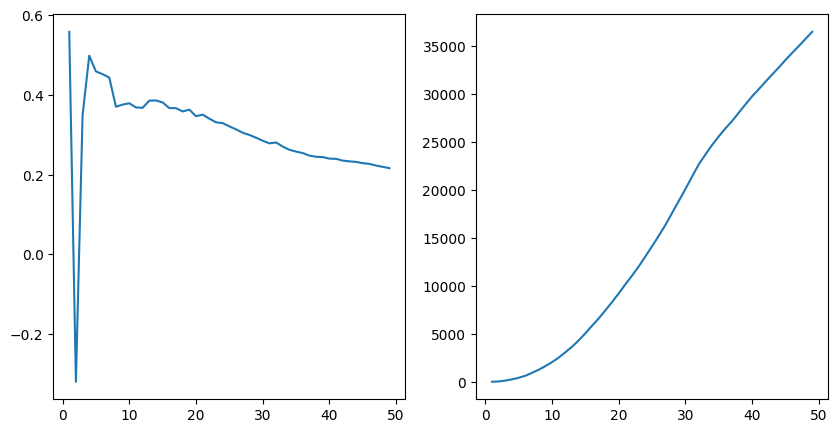

In [164]:
distances = range(1, 50)
r2s, num_matches = calculate_error_for_distances(compare_2020_to_2021, distances, 'agbd', 'agbd_after')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=distances, y=r2s, ax=ax[0])
sns.lineplot(x=distances, y=num_matches, ax=ax[1])

<Axes: >

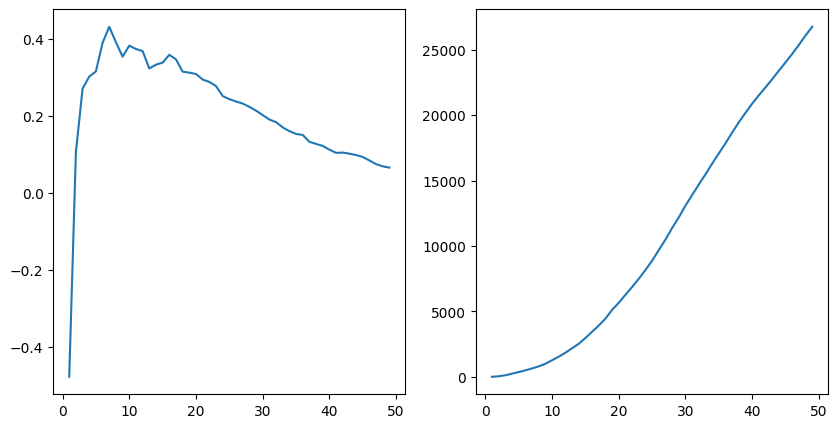

In [165]:
distances = range(1, 50)
r2s, num_matches = calculate_error_for_distances(compare_2021_to_2022, distances, 'agbd', 'agbd_after')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=distances, y=r2s, ax=ax[0])
sns.lineplot(x=distances, y=num_matches, ax=ax[1])

<Axes: >

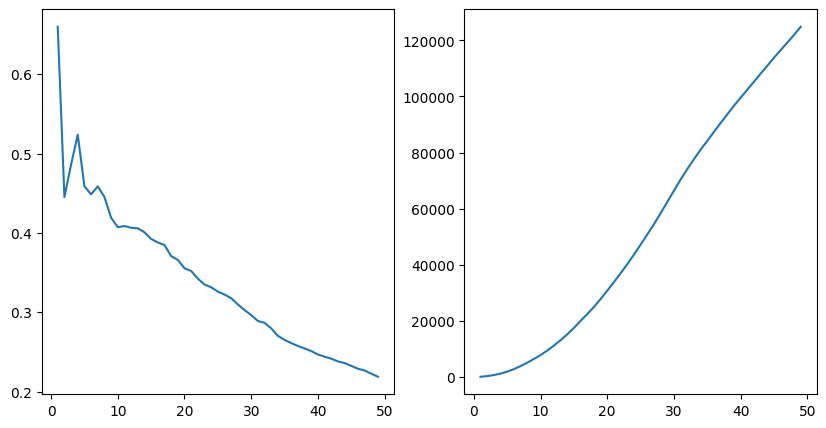

In [169]:
distances = range(1, 50)
r2s, num_matches = calculate_error_for_distances(compare_all, distances, 'agbd', 'agbd_after')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=distances, y=r2s, ax=ax[0])
sns.lineplot(x=distances, y=num_matches, ax=ax[1])

In [170]:
# Fit normal
f = Fitter(get_closest_matches(compare_all, 20).agbd_diff.values,
           distributions=["norm"])

f.fit()
#f.summary()
f.get_best(method = 'sumsquare_error')

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


{'norm': {'loc': 4.01684466850936, 'scale': 103.3315354088194}}

For 2019 to 2020 there seems to be a significant difference attached to seasonality, but overall it doesn't really make much of a difference.

It would be good to also plot R2 as a function of time difference between two shots, but let's not go into too many details right now, and proceed to evaluate AGBD on low, medium, high severities.

Then, do PAI and PAI z metrics as well

## Evaluating AGBD as a function of fire severity for all fires

Here we're only going to group GEDI shots into before and after. Later we can take a look at per year recovery of the metric.

In [208]:
# Clean up perimeter data.
firep = sierra_firep.perimeters.dropna(subset=['ALARM_DATE', 'CONT_DATE', 'FIRE_NAME']).drop(columns=['index_right'])

In [232]:
firep = firep[firep.FIRE_NAME != 'W-4 TERMO']

In [241]:
firep = firep[firep.FIRE_NAME != 'BEALE2']

In [240]:
pd.to_datetime(firep[firep.FIRE_NAME == 'BEALE2'].ALARM_DATE.iloc[0])

Timestamp('2021-10-12 00:00:00+0000', tz='UTC')

In [238]:
firep[firep.FIRE_NAME == 'FORBESTOWN'].ALARM_DATE

20964    2019-09-06T00:00:00+00:00
Name: ALARM_DATE, dtype: object

In [ ]:
firep.at[]

In [217]:
import importlib
importlib.reload(k_nn)

<module 'src.data.k_nn' from '/home/jk871/fire-regen/src/data/k_nn.py'>

In [242]:
all_matches = []
for year in ['2019', '2020', '2021', '2022']:
    print(f'Processing year {year}')
    firep_year = firep[firep.YEAR_ == year]
    for row in firep_year.itertuples():
        print(f'Processing fire {row.FIRE_NAME} and {row.INC_NUM}')
        fire = Fire(firep_year[(firep_year.INC_NUM == row.INC_NUM) & (firep_year.FIRE_NAME == row.FIRE_NAME)])

        gedi_before = gedi_burned[gedi_burned.absolute_time < fire.alarm_date].sjoin(fire.fire, how="inner", predicate="within")
        gedi_after = gedi_burned[gedi_burned.absolute_time > fire.cont_date].sjoin(fire.fire, how="inner", predicate="within")

        print(gedi_before.shape[0], gedi_after.shape[0])
        if gedi_before.shape[0] == 0 or gedi_after.shape[0] == 0:
            # No GEDI shots at the fire area found. Skip this fire.
            print(f'Skipped fire {row.FIRE_NAME}. No matching GEDI shots found.')
            continue
        matches = find_matches(gedi_before, gedi_after, 'agbd')
        all_matches.append(matches)

Processing year 2019
Processing fire SWEDES and 00010594
34 114
Processing fire FORBESTOWN and 00010635
0 11
Skipped fire FORBESTOWN. No matching GEDI shots found.
Processing fire CREEK_4 and 00000684
0 0
Skipped fire CREEK_4. No matching GEDI shots found.
Processing fire GROVE and 01948217
0 0
Skipped fire GROVE. No matching GEDI shots found.
Processing fire MESA and 01931668
0 0
Skipped fire MESA. No matching GEDI shots found.
Processing fire CARSON and 00023015
0 0
Skipped fire CARSON. No matching GEDI shots found.
Processing fire CHAPARRAL and 00029708
0 0
Skipped fire CHAPARRAL. No matching GEDI shots found.
Processing fire COULTER and 00028812
0 0
Skipped fire COULTER. No matching GEDI shots found.
Processing fire COUNTRY and 00026999
0 0
Skipped fire COUNTRY. No matching GEDI shots found.
Processing fire ELECTRA and 00029257
0 0
Skipped fire ELECTRA. No matching GEDI shots found.
Processing fire PATTERSON and 00024851
0 0
Skipped fire PATTERSON. No matching GEDI shots found.
Pro

In [243]:
matches = pd.concat(all_matches)

In [245]:
matches.shape[0]

176487

In [272]:
perfect_matches = matches[matches.burn_severity_std==0]

In [246]:
perfect_matches.shape[0]

105536

In [273]:
perfect_matches = matches[matches.burn_severity_std==0]
perfect_matches = perfect_matches[(perfect_matches.land_cover_std == 0) & (perfect_matches.land_cover_median==1)]

(0.0, 700.0)

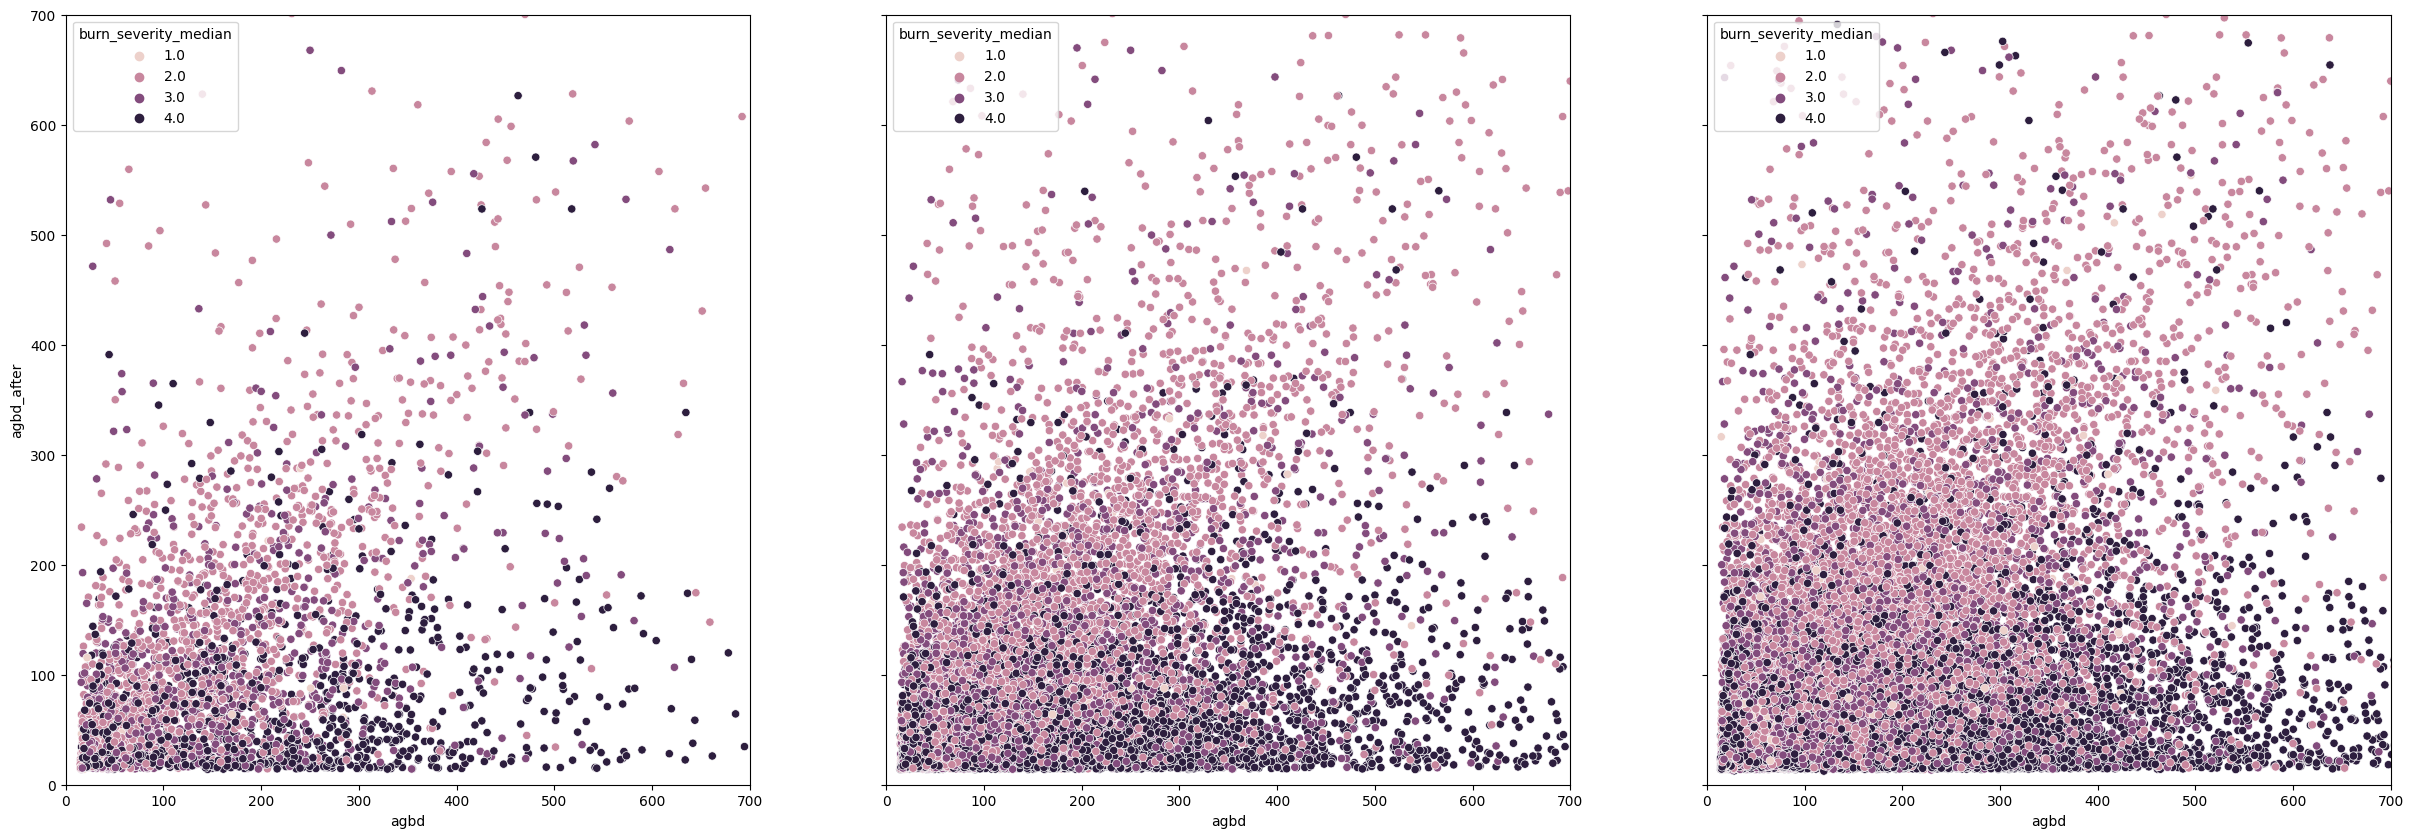

In [247]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10), sharex=True, sharey=True)
sns.scatterplot(get_closest_matches(perfect_matches, 10), x='agbd', y='agbd_after', hue="burn_severity_median", ax=ax[0])
sns.scatterplot(get_closest_matches(perfect_matches, 20), x='agbd', y='agbd_after', hue="burn_severity_median", ax=ax[1])
sns.scatterplot(get_closest_matches(perfect_matches, 30), x='agbd', y='agbd_after', hue="burn_severity_median", ax=ax[2])
ax[0].set_ylim((0, 700))
ax[0].set_xlim((0, 700))

## Analysis per severity

### Low severity

In [274]:
low_severity = perfect_matches[perfect_matches.burn_severity_median == 2]

(0.0, 700.0)

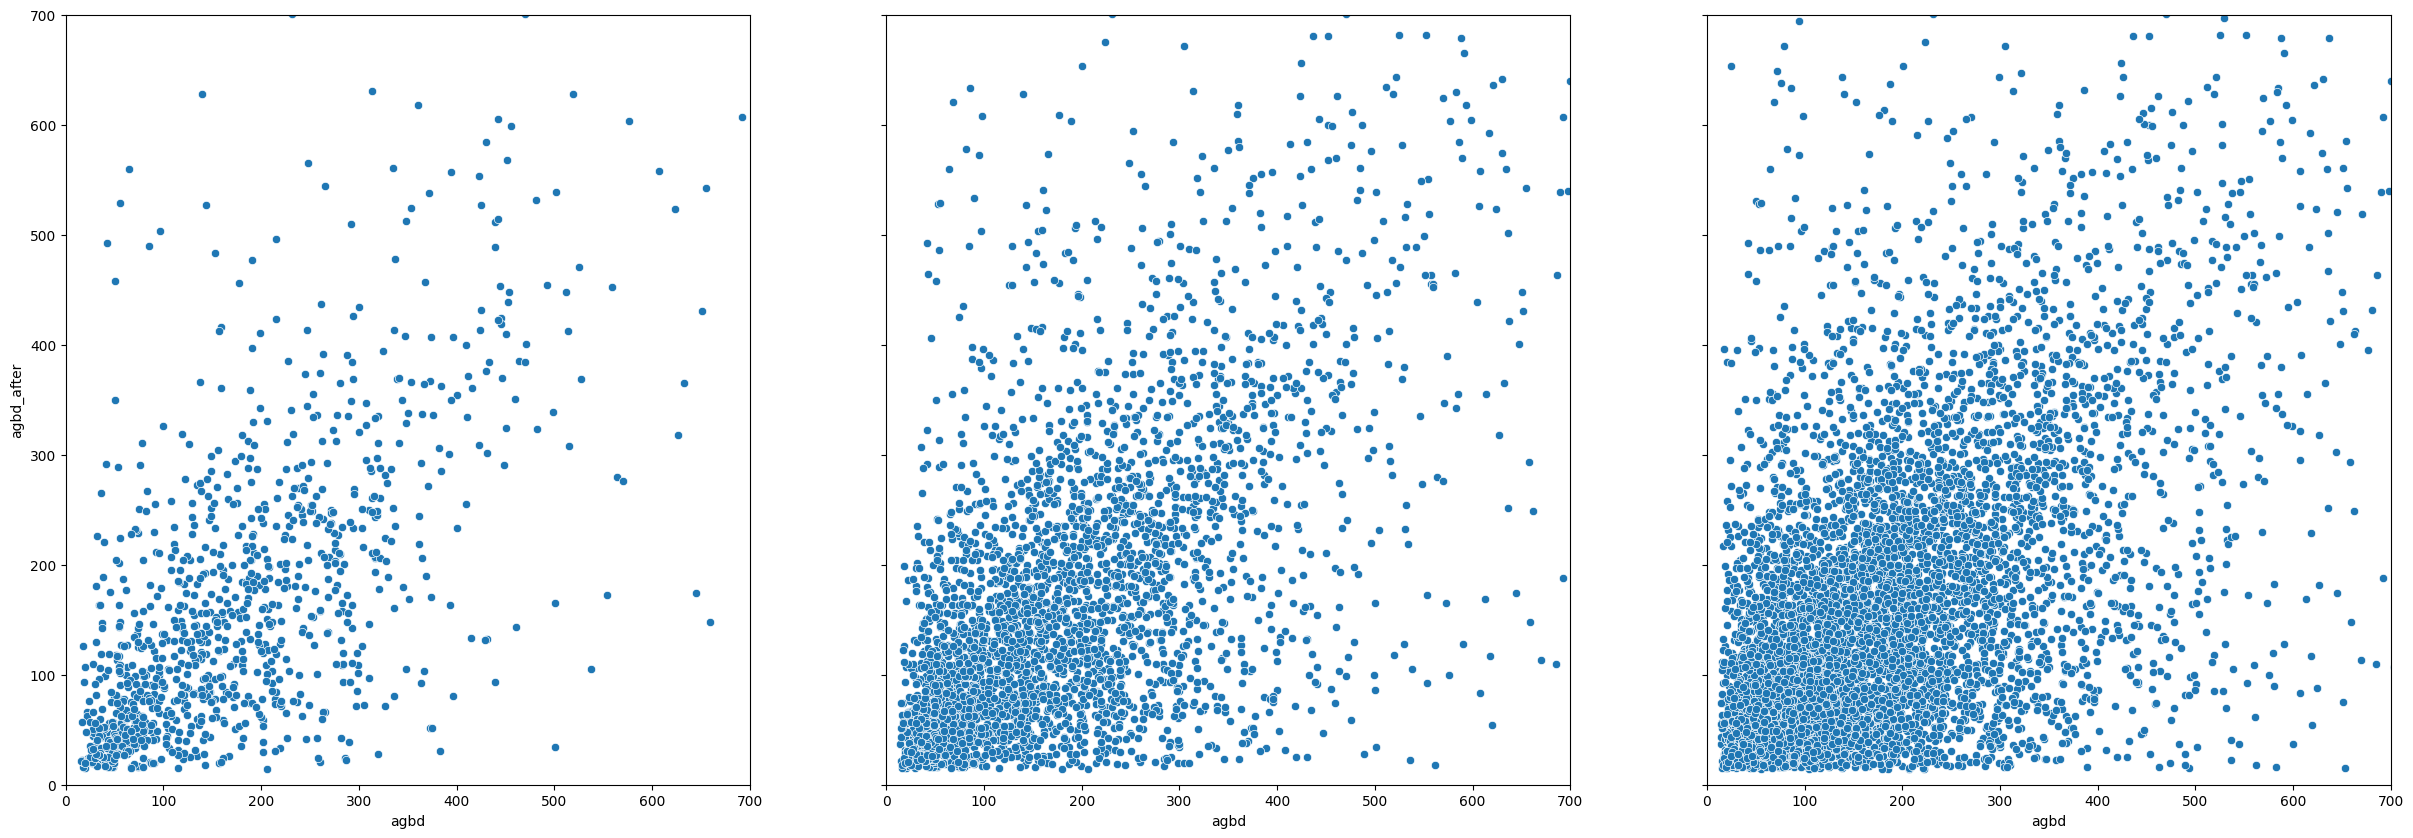

In [275]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10), sharex=True, sharey=True)
sns.scatterplot(get_closest_matches(low_severity, 10), x='agbd', y='agbd_after', ax=ax[0])
sns.scatterplot(get_closest_matches(low_severity, 20), x='agbd', y='agbd_after',  ax=ax[1])
sns.scatterplot(get_closest_matches(low_severity, 30), x='agbd', y='agbd_after',  ax=ax[2])
ax[0].set_ylim((0, 700))
ax[0].set_xlim((0, 700))

<Axes: >

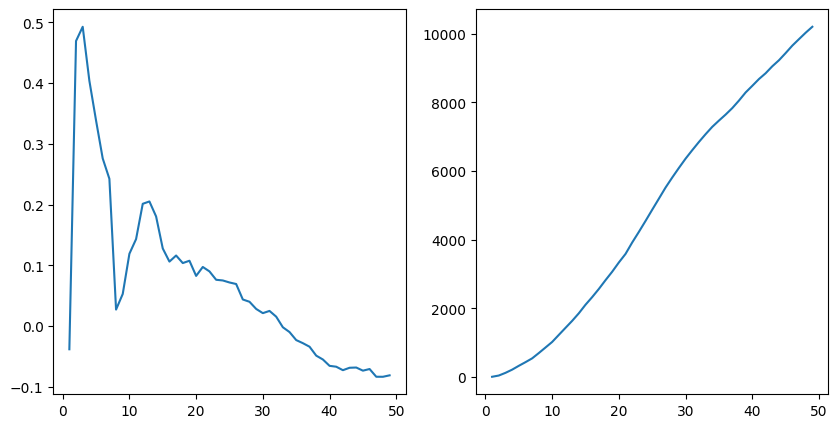

In [276]:
distances = range(1, 50)
r2s, num_matches = calculate_error_for_distances(low_severity, distances, 'agbd', 'agbd_after')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=distances, y=r2s, ax=ax[0])
sns.lineplot(x=distances, y=num_matches, ax=ax[1])

Best Linear regression coefficient is [0.57738634]. R squared is: 0.31462653324604317.
The error for coeff = 1 is: 0.08261981815967645.


(0.0, 1000.0)

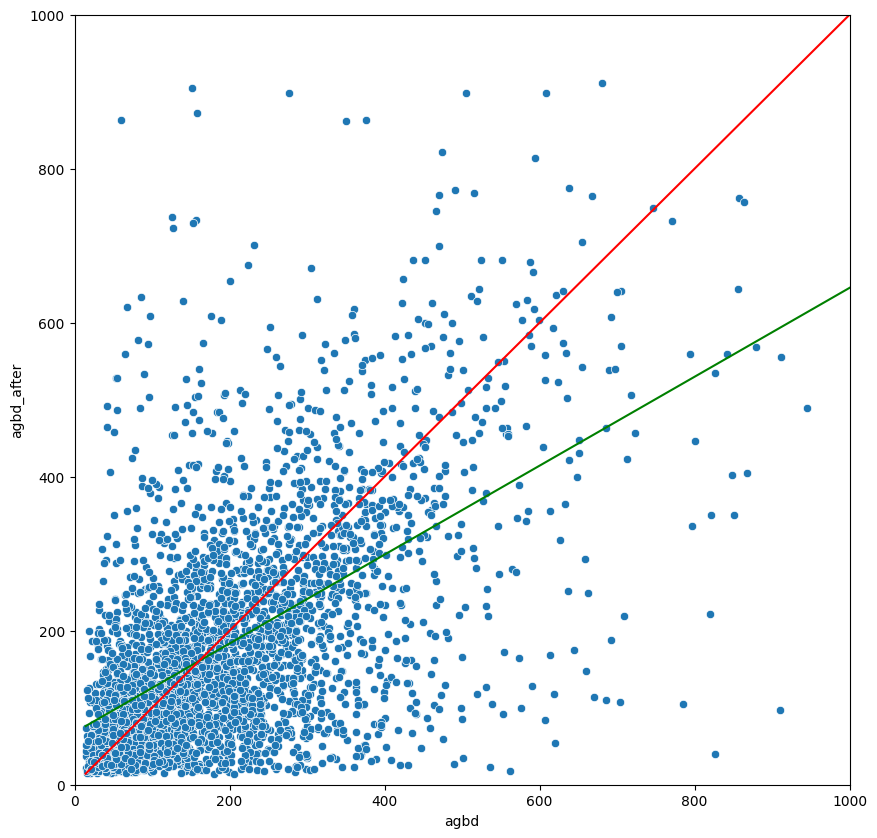

In [277]:
dist_10 = get_closest_matches(low_severity, 20)
reg_10 = LinearRegression().fit(np.reshape(dist_10.agbd.values, (dist_10.shape[0], 1)), dist_10.agbd_after.values)
score = reg_10.score(np.reshape(dist_10.agbd.values, (dist_10.shape[0], 1)), dist_10.agbd_after.values)
print(f'Best Linear regression coefficient is {reg_10.coef_}. R squared is: {score}.')

print(f'The error for coeff = 1 is: {r2_score(dist_10.agbd.values, dist_10.agbd_after.values)}.')

fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
sns.scatterplot(dist_10, x='agbd', y='agbd_after', ax=ax)
sns.lineplot(x=dist_10.agbd.values, y=reg_10.predict(np.reshape(dist_10.agbd.values, (dist_10.shape[0], 1))), color='green')
sns.lineplot(x=dist_10.agbd.values, y=dist_10.agbd.values, color='red')
ax.set_xlim((0, 1000))
ax.set_ylim((0, 1000))

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  8.02it/s]


sumsquare_error          aic           bic  kl_div  ks_statistic  \
lognorm         0.000013  5041.283346 -64495.917356     inf      0.100050   
norm            0.000014  4932.773541 -64470.330634     inf      0.096967   
beta            0.000014  4923.738952 -64453.926994     inf      0.096954   
gamma           0.000016  5627.127858 -63904.091786     inf      0.125538   
burr            0.000117  1955.601291 -57271.411321     inf      0.614787   

            ks_pvalue  
lognorm  1.537433e-29  
norm     9.032555e-28  
beta     9.189552e-28  
gamma    2.589936e-46  
burr     0.000000e+00

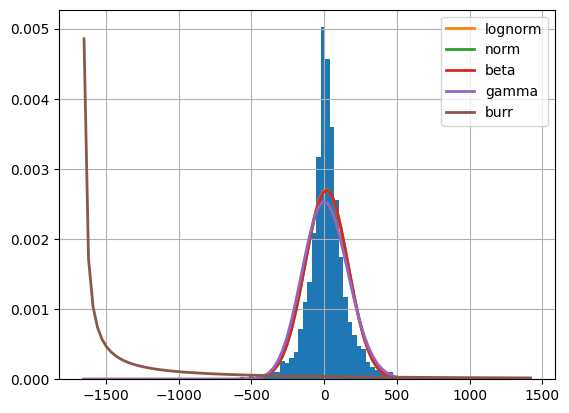

In [286]:
f = Fitter(get_closest_matches(low_severity, 20).agbd_diff.values,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])

f.fit()
f.summary()

In [287]:
# Fit normal
f = Fitter(get_closest_matches(low_severity, 20).agbd_diff.values,
           distributions=["norm"])

f.fit()
#f.summary()
f.get_best(method = 'sumsquare_error')

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


{'norm': {'loc': 17.40815723206627, 'scale': 147.73422286653152}}

In [296]:
stats.wilcoxon(get_closest_matches(low_severity, 20).agbd, get_closest_matches(low_severity, 20).agbd_after)

WilcoxonResult(statistic=2282849.0, pvalue=1.5270290397616043e-19)

### Medium Severity

In [278]:
medium_severity = perfect_matches[perfect_matches.burn_severity_median == 3]

(0.0, 700.0)

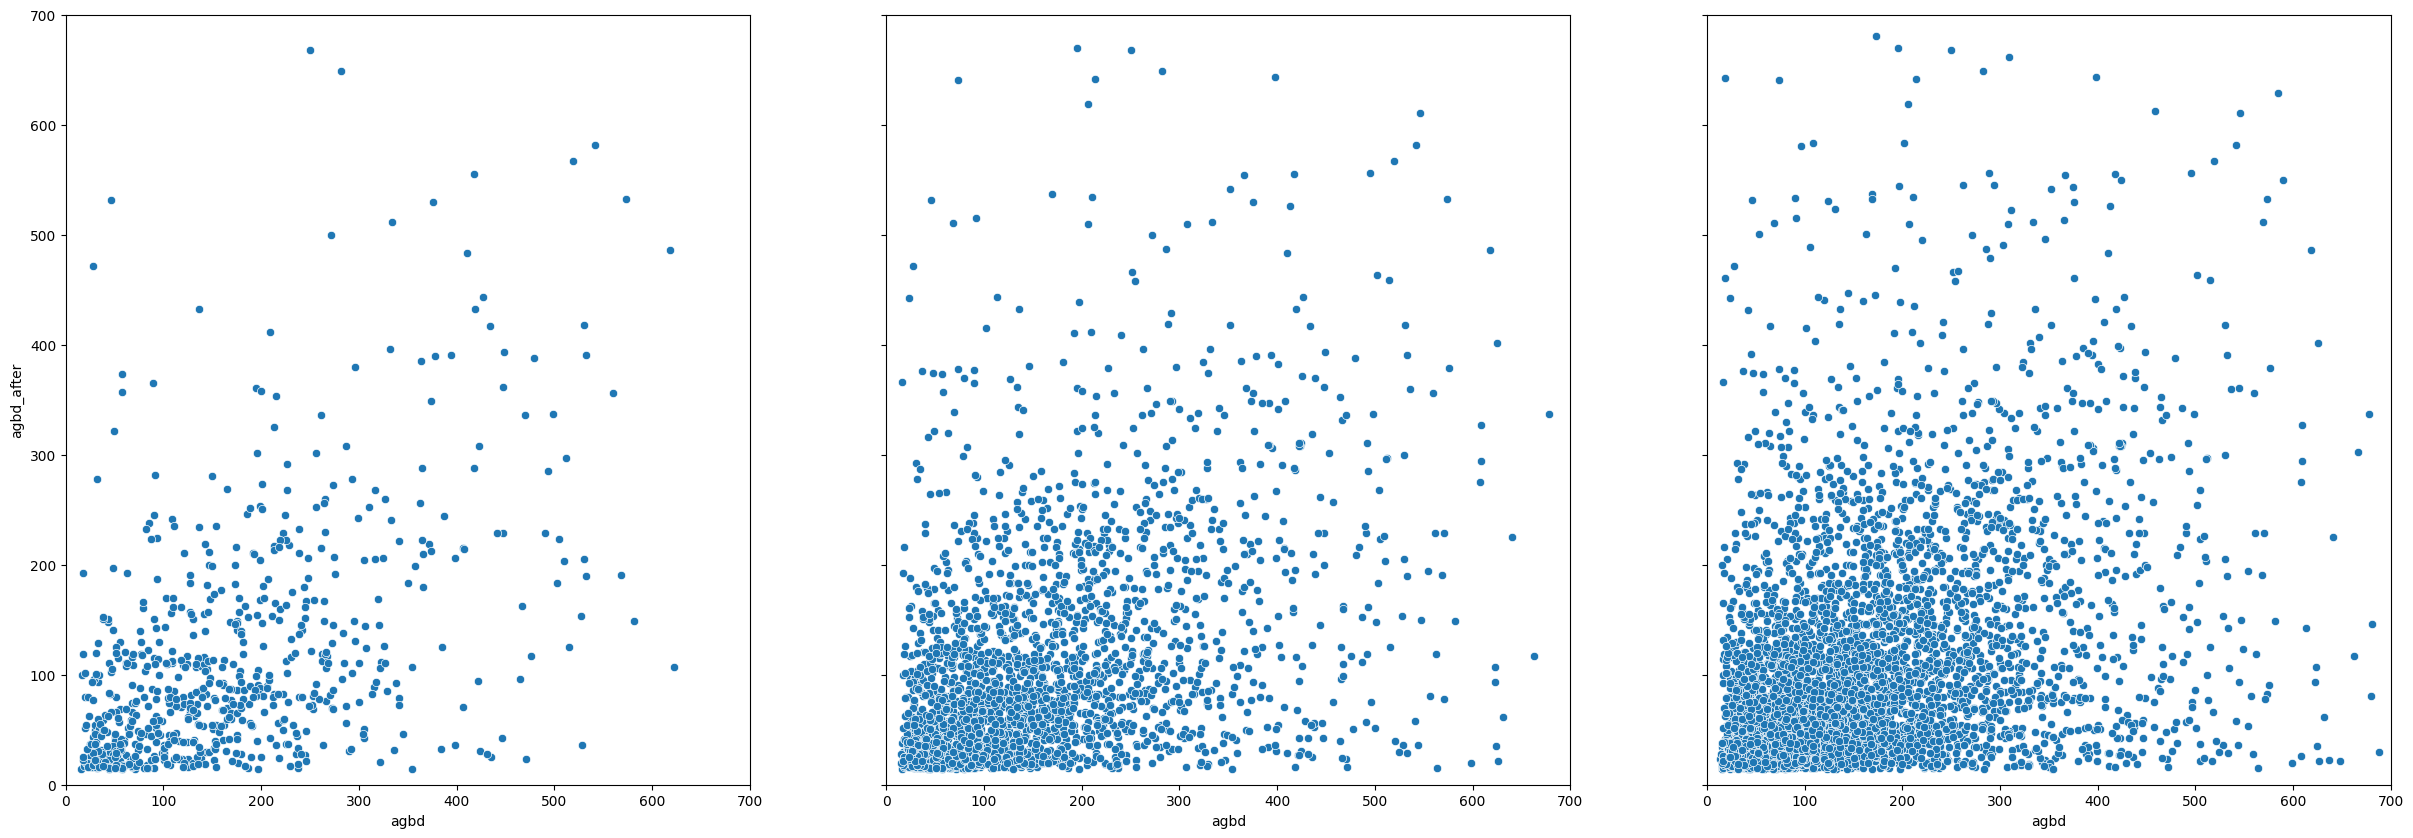

In [279]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10), sharex=True, sharey=True)
sns.scatterplot(get_closest_matches(medium_severity, 10), x='agbd', y='agbd_after', ax=ax[0])
sns.scatterplot(get_closest_matches(medium_severity, 20), x='agbd', y='agbd_after',  ax=ax[1])
sns.scatterplot(get_closest_matches(medium_severity, 30), x='agbd', y='agbd_after',  ax=ax[2])
ax[0].set_ylim((0, 700))
ax[0].set_xlim((0, 700))

<Axes: >

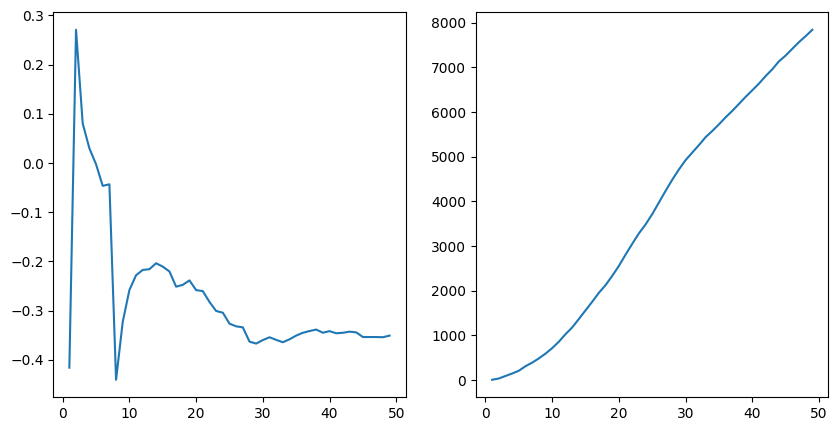

In [280]:
distances = range(1, 50)
r2s, num_matches = calculate_error_for_distances(medium_severity, distances, 'agbd', 'agbd_after')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=distances, y=r2s, ax=ax[0])
sns.lineplot(x=distances, y=num_matches, ax=ax[1])

Best Linear regression coefficient is [0.31557787]. R squared is: 0.13578044041370974.
The error for coeff = 1 is: -0.25835405412969203.


(0.0, 1000.0)

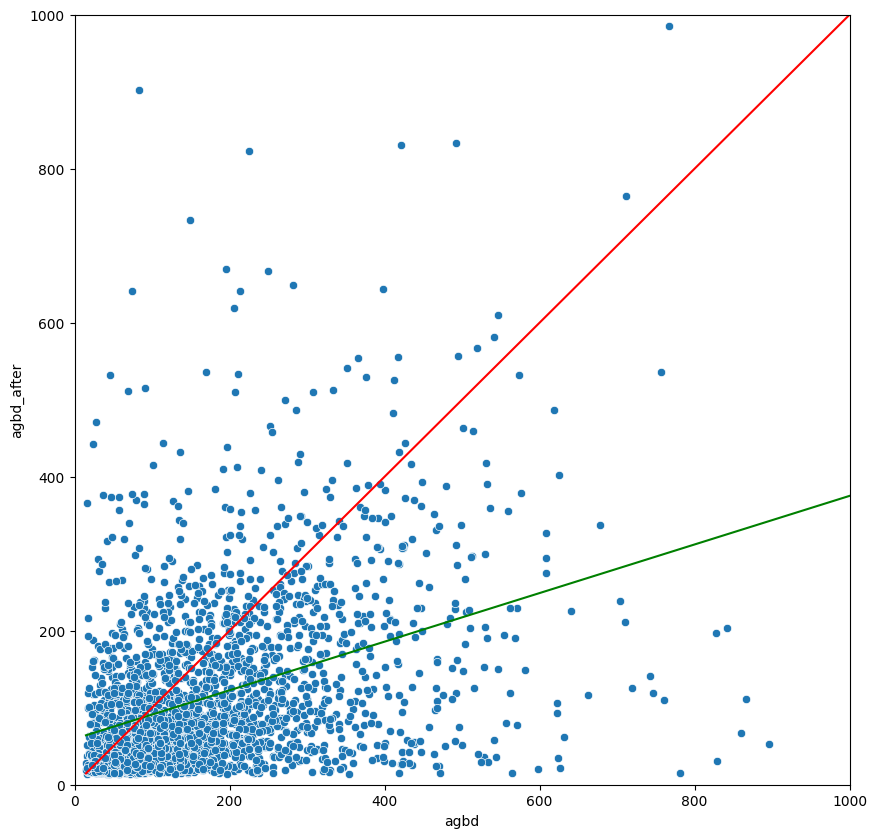

In [281]:
dist_10 = get_closest_matches(medium_severity, 20)
reg_10 = LinearRegression().fit(np.reshape(dist_10.agbd.values, (dist_10.shape[0], 1)), dist_10.agbd_after.values)
score = reg_10.score(np.reshape(dist_10.agbd.values, (dist_10.shape[0], 1)), dist_10.agbd_after.values)
print(f'Best Linear regression coefficient is {reg_10.coef_}. R squared is: {score}.')

print(f'The error for coeff = 1 is: {r2_score(dist_10.agbd.values, dist_10.agbd_after.values)}.')

fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
sns.scatterplot(dist_10, x='agbd', y='agbd_after', ax=ax)
sns.lineplot(x=dist_10.agbd.values, y=reg_10.predict(np.reshape(dist_10.agbd.values, (dist_10.shape[0], 1))), color='green')
sns.lineplot(x=dist_10.agbd.values, y=dist_10.agbd.values, color='red')
ax.set_xlim((0, 1000))
ax.set_ylim((0, 1000))

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  5.69it/s]


sumsquare_error          aic           bic  kl_div  ks_statistic  \
norm            0.000017  5298.803627 -48024.924269     inf      0.117391   
beta            0.000017  5301.277222 -48006.654660     inf      0.117780   
gamma           0.000018  5371.469455 -47979.047718     inf      0.122584   
lognorm         0.000106  2068.297581 -43388.523042     inf      0.805359   
burr            0.000113  2013.640264 -43227.070526     inf      0.686932   

            ks_pvalue  
norm     4.023283e-31  
beta     2.512699e-31  
gamma    6.621067e-34  
lognorm  0.000000e+00  
burr     0.000000e+00

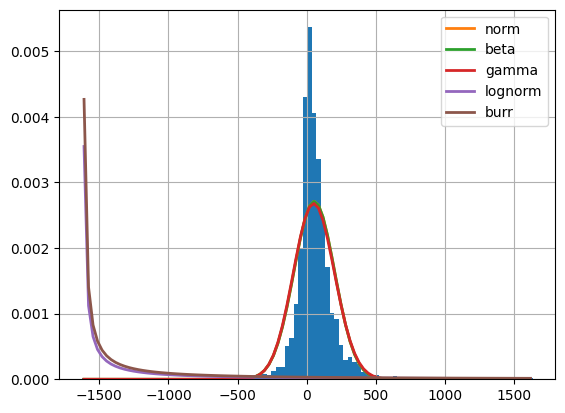

In [289]:
f = Fitter(get_closest_matches(medium_severity, 20).agbd_diff.values,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])

f.fit()
f.summary()

In [290]:
# Fit normal
f = Fitter(get_closest_matches(medium_severity, 20).agbd_diff.values,
           distributions=["norm"])

f.fit()
#f.summary()
f.get_best(method = 'sumsquare_error')

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 20.30it/s]


{'norm': {'loc': 55.34133702810612, 'scale': 147.0846231365418}}

In [295]:
stats.wilcoxon(get_closest_matches(medium_severity, 20).agbd, get_closest_matches(medium_severity, 20).agbd_after)

WilcoxonResult(statistic=756172.0, pvalue=6.216119663119623e-122)

### High Severity

In [282]:
high_severity = perfect_matches[perfect_matches.burn_severity_median == 4]

(0.0, 700.0)

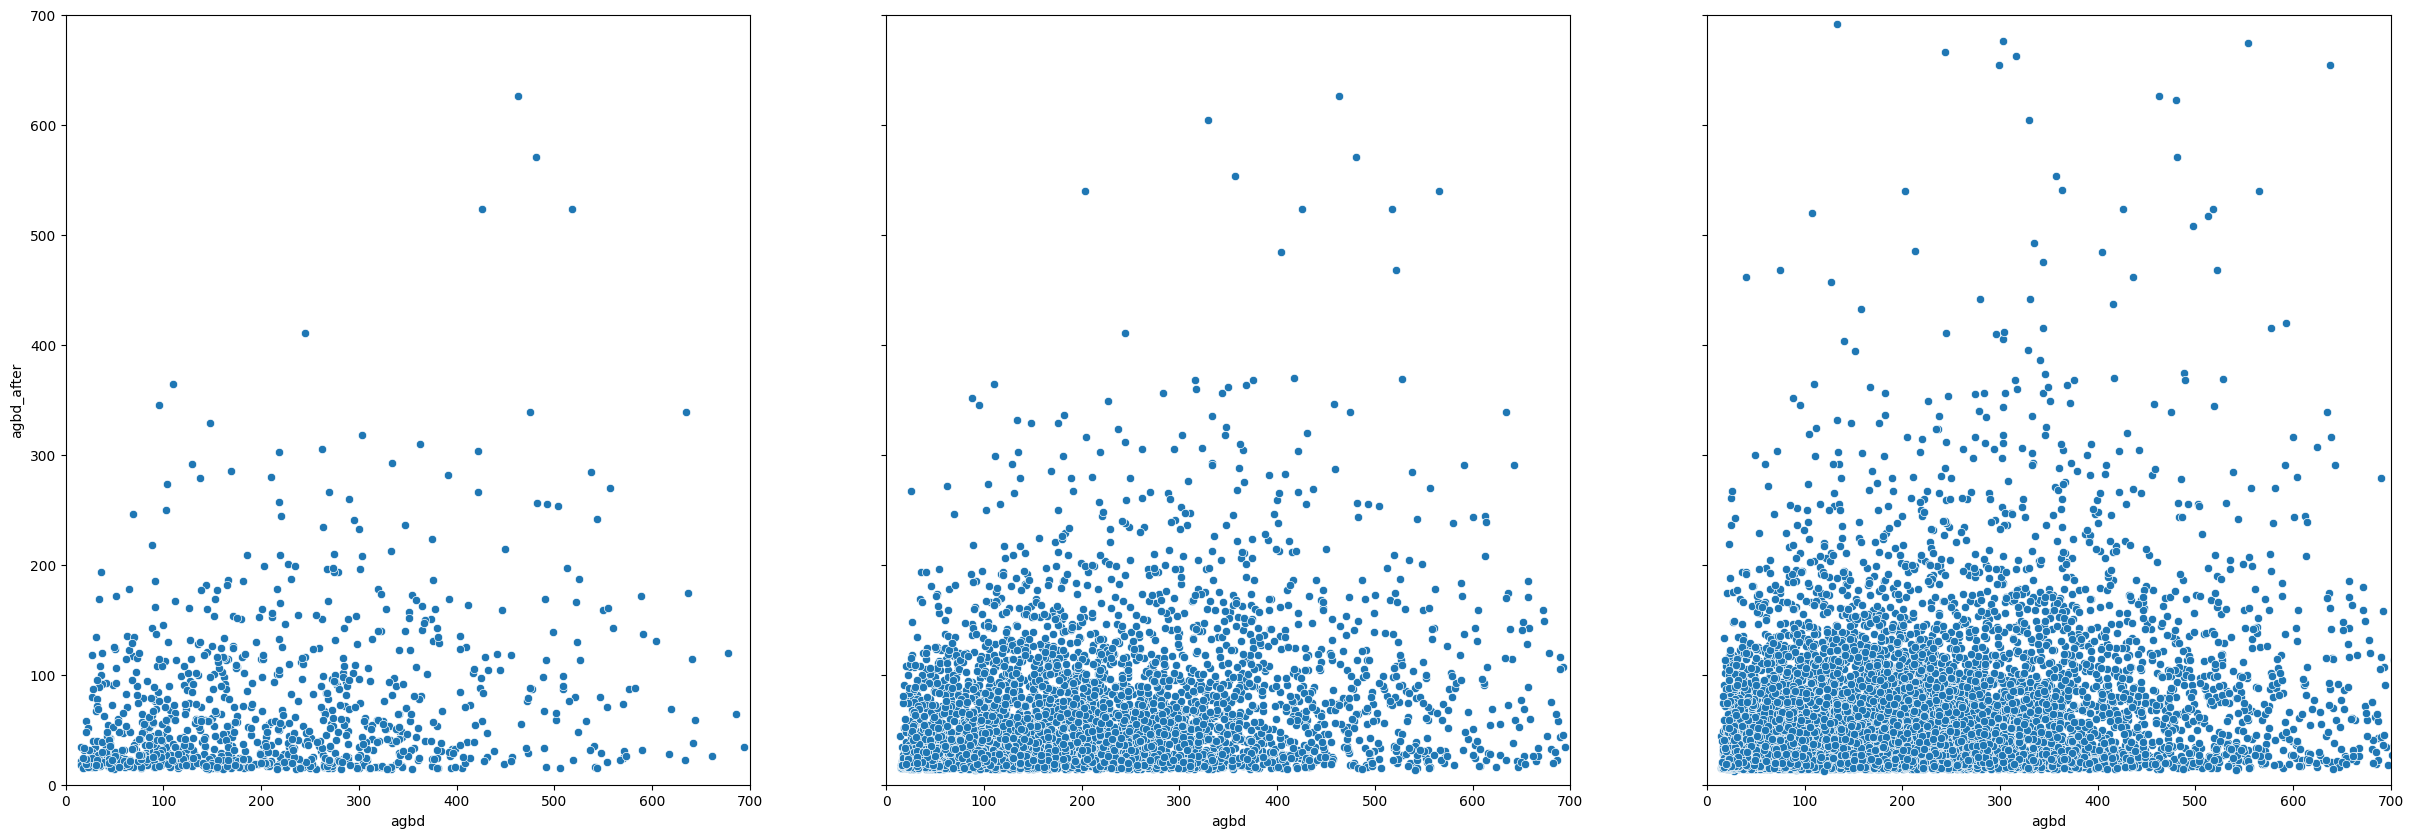

In [283]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10), sharex=True, sharey=True)
sns.scatterplot(get_closest_matches(high_severity, 10), x='agbd', y='agbd_after', ax=ax[0])
sns.scatterplot(get_closest_matches(high_severity, 20), x='agbd', y='agbd_after',  ax=ax[1])
sns.scatterplot(get_closest_matches(high_severity, 30), x='agbd', y='agbd_after',  ax=ax[2])
ax[0].set_ylim((0, 700))
ax[0].set_xlim((0, 700))

<Axes: >

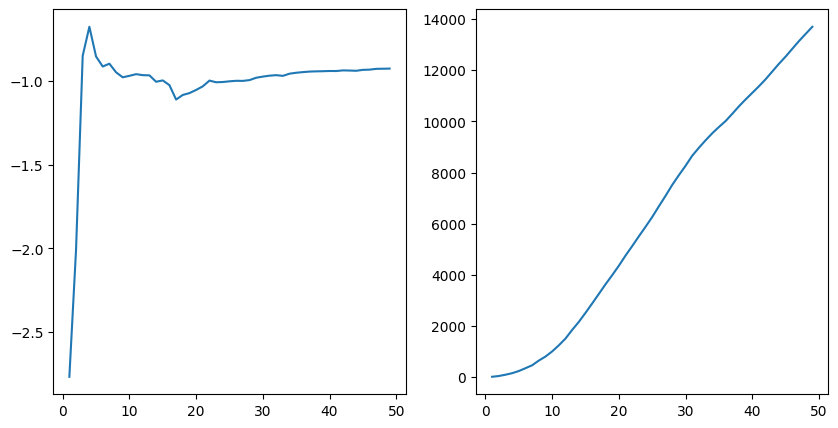

In [284]:
distances = range(1, 50)
r2s, num_matches = calculate_error_for_distances(high_severity, distances, 'agbd', 'agbd_after')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=distances, y=r2s, ax=ax[0])
sns.lineplot(x=distances, y=num_matches, ax=ax[1])

Best Linear regression coefficient is [0.08705549]. R squared is: 0.029188346115476937.
The error for coeff = 1 is: -1.0532543853319272.


(0.0, 1000.0)

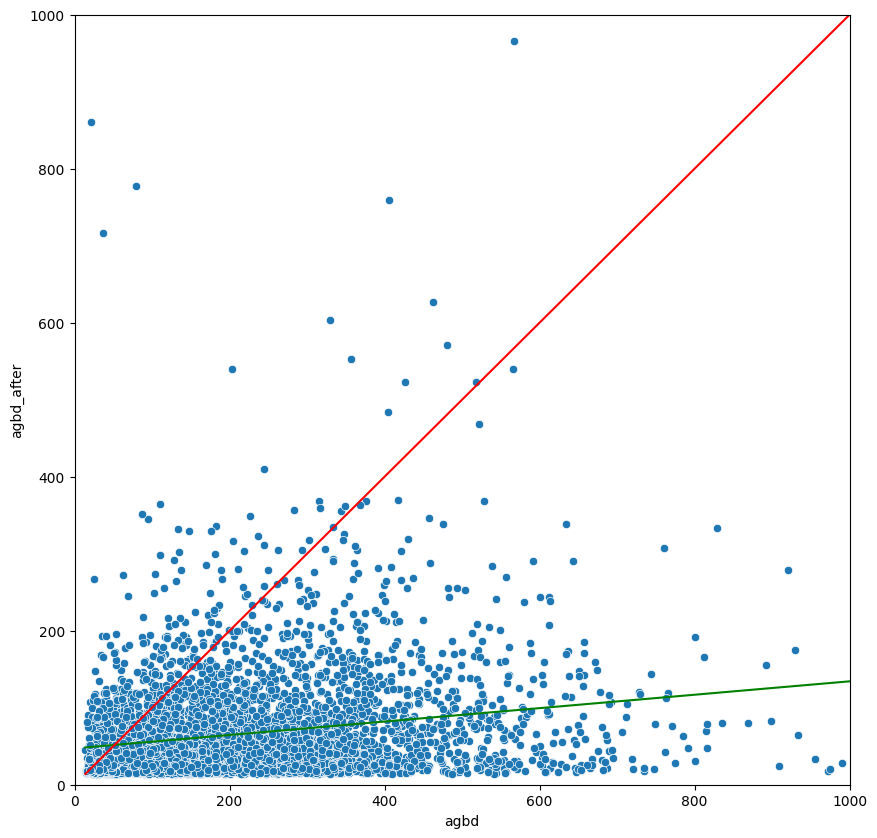

In [285]:
dist_10 = get_closest_matches(high_severity, 20)
reg_10 = LinearRegression().fit(np.reshape(dist_10.agbd.values, (dist_10.shape[0], 1)), dist_10.agbd_after.values)
score = reg_10.score(np.reshape(dist_10.agbd.values, (dist_10.shape[0], 1)), dist_10.agbd_after.values)
print(f'Best Linear regression coefficient is {reg_10.coef_}. R squared is: {score}.')

print(f'The error for coeff = 1 is: {r2_score(dist_10.agbd.values, dist_10.agbd_after.values)}.')

fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
sns.scatterplot(dist_10, x='agbd', y='agbd_after', ax=ax)
sns.lineplot(x=dist_10.agbd.values, y=reg_10.predict(np.reshape(dist_10.agbd.values, (dist_10.shape[0], 1))), color='green')
sns.lineplot(x=dist_10.agbd.values, y=dist_10.agbd.values, color='red')
ax.set_xlim((0, 1000))
ax.set_ylim((0, 1000))

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


sumsquare_error          aic           bic  kl_div  ks_statistic  \
gamma           0.000008  5598.173642 -87535.282023     inf      0.084361   
norm            0.000008  5034.182585 -87392.589257     inf      0.083228   
beta            0.000008  5036.447346 -87374.965142     inf      0.083233   
lognorm         0.000095  2034.967261 -76806.980113     inf      0.808560   
burr            0.000105  1997.608080 -76360.406783     inf      0.753115   

            ks_pvalue  
gamma    2.063823e-27  
norm     1.085234e-26  
beta     1.076276e-26  
lognorm  0.000000e+00  
burr     0.000000e+00

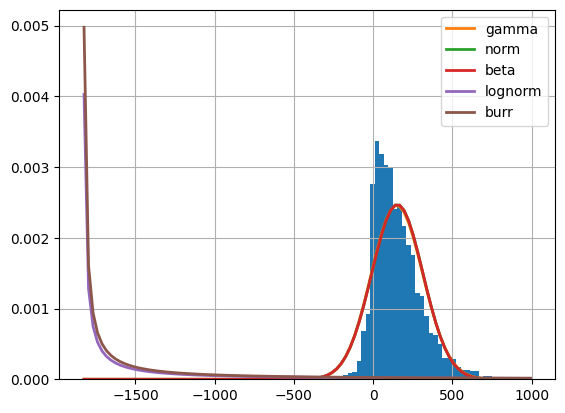

In [291]:
f = Fitter(get_closest_matches(high_severity, 20).agbd_diff.values,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])

f.fit()
f.summary()

In [292]:
# Fit normal
f = Fitter(get_closest_matches(high_severity, 20).agbd_diff.values,
           distributions=["norm"])

f.fit()
#f.summary()
f.get_best(method = 'sumsquare_error')

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 23.15it/s]


{'norm': {'loc': 152.42262278774712, 'scale': 161.43471530122022}}

In [293]:
stats.wilcoxon(get_closest_matches(high_severity, 20).agbd, get_closest_matches(high_severity, 20).agbd_after)

WilcoxonResult(statistic=408199.0, pvalue=0.0)

### Short-term AGBD recovery

Let's look at AGBD_before - AGBD_after as a function of time_since_fire. We can aggregate like so - 3 months, 6 months, 1 year, 2 years, 3 years since fire.

In [304]:
all_matches = []
for year in ['2019', '2020', '2021', '2022']:
    print(f'Processing year {year}')
    firep_year = firep[firep.YEAR_ == year]
    for row in firep_year.itertuples():
        print(f'Processing fire {row.FIRE_NAME} and {row.INC_NUM}')
        fire = Fire(firep_year[(firep_year.INC_NUM == row.INC_NUM) & (firep_year.FIRE_NAME == row.FIRE_NAME)])

        gedi_before = gedi_burned[gedi_burned.absolute_time < fire.alarm_date].sjoin(fire.fire, how="inner", predicate="within")
        gedi_after = gedi_burned[(gedi_burned.absolute_time > fire.cont_date) & (gedi_burned.absolute_time < fire.cont_date + pd.DateOffset(months=3))].sjoin(fire.fire, how="inner", predicate="within")

        print(gedi_before.shape[0], gedi_after.shape[0])
        if gedi_before.shape[0] == 0 or gedi_after.shape[0] == 0:
            # No GEDI shots at the fire area found. Skip this fire.
            print(f'Skipped fire {row.FIRE_NAME}. No matching GEDI shots found.')
            continue
        matches = find_matches(gedi_before, gedi_after, 'agbd')
        all_matches.append(matches)
months_3_matches = pd.concat(all_matches)

Processing year 2019
Processing fire SWEDES and 00010594
34 1
Processing fire FORBESTOWN and 00010635
0 0
Skipped fire FORBESTOWN. No matching GEDI shots found.
Processing fire CREEK_4 and 00000684
0 0
Skipped fire CREEK_4. No matching GEDI shots found.
Processing fire GROVE and 01948217
0 0
Skipped fire GROVE. No matching GEDI shots found.
Processing fire MESA and 01931668
0 0
Skipped fire MESA. No matching GEDI shots found.
Processing fire CARSON and 00023015
0 0
Skipped fire CARSON. No matching GEDI shots found.
Processing fire CHAPARRAL and 00029708
0 0
Skipped fire CHAPARRAL. No matching GEDI shots found.
Processing fire COULTER and 00028812
0 0
Skipped fire COULTER. No matching GEDI shots found.
Processing fire COUNTRY and 00026999
0 0
Skipped fire COUNTRY. No matching GEDI shots found.
Processing fire ELECTRA and 00029257
0 0
Skipped fire ELECTRA. No matching GEDI shots found.
Processing fire PATTERSON and 00024851
0 0
Skipped fire PATTERSON. No matching GEDI shots found.
Proces

In [317]:
months_3_perfect_matches = months_3_matches[months_3_matches.burn_severity_std==0]
months_3_perfect_matches = months_3_perfect_matches[(months_3_perfect_matches.land_cover_std == 0) & (months_3_perfect_matches.land_cover_median==1)]

In [309]:
all_matches = []
for year in ['2019', '2020', '2021', '2022']:
    print(f'Processing year {year}')
    firep_year = firep[firep.YEAR_ == year]
    for row in firep_year.itertuples():
        print(f'Processing fire {row.FIRE_NAME} and {row.INC_NUM}')
        fire = Fire(firep_year[(firep_year.INC_NUM == row.INC_NUM) & (firep_year.FIRE_NAME == row.FIRE_NAME)])

        gedi_before = gedi_burned[gedi_burned.absolute_time < fire.alarm_date].sjoin(fire.fire, how="inner", predicate="within")
        gedi_after = gedi_burned[(gedi_burned.absolute_time > fire.cont_date + pd.DateOffset(months=3)) & (gedi_burned.absolute_time < fire.cont_date + pd.DateOffset(months=6))].sjoin(fire.fire, how="inner", predicate="within")

        print(gedi_before.shape[0], gedi_after.shape[0])
        if gedi_before.shape[0] == 0 or gedi_after.shape[0] == 0:
            # No GEDI shots at the fire area found. Skip this fire.
            print(f'Skipped fire {row.FIRE_NAME}. No matching GEDI shots found.')
            continue
        matches = find_matches(gedi_before, gedi_after, 'agbd')
        all_matches.append(matches)
months_6_matches = pd.concat(all_matches)

Processing year 2019
Processing fire SWEDES and 00010594
34 0
Skipped fire SWEDES. No matching GEDI shots found.
Processing fire FORBESTOWN and 00010635
0 0
Skipped fire FORBESTOWN. No matching GEDI shots found.
Processing fire CREEK_4 and 00000684
0 0
Skipped fire CREEK_4. No matching GEDI shots found.
Processing fire GROVE and 01948217
0 0
Skipped fire GROVE. No matching GEDI shots found.
Processing fire MESA and 01931668
0 0
Skipped fire MESA. No matching GEDI shots found.
Processing fire CARSON and 00023015
0 0
Skipped fire CARSON. No matching GEDI shots found.
Processing fire CHAPARRAL and 00029708
0 0
Skipped fire CHAPARRAL. No matching GEDI shots found.
Processing fire COULTER and 00028812
0 0
Skipped fire COULTER. No matching GEDI shots found.
Processing fire COUNTRY and 00026999
0 0
Skipped fire COUNTRY. No matching GEDI shots found.
Processing fire ELECTRA and 00029257
0 0
Skipped fire ELECTRA. No matching GEDI shots found.
Processing fire PATTERSON and 00024851
0 0
Skipped f

In [318]:
months_6_perfect_matches = months_6_matches[months_6_matches.burn_severity_std==0]
months_6_perfect_matches = months_6_perfect_matches[(months_6_perfect_matches.land_cover_std == 0) & (months_6_perfect_matches.land_cover_median==1)]

In [312]:
all_matches = []
for year in ['2019', '2020', '2021', '2022']:
    print(f'Processing year {year}')
    firep_year = firep[firep.YEAR_ == year]
    for row in firep_year.itertuples():
        print(f'Processing fire {row.FIRE_NAME} and {row.INC_NUM}')
        fire = Fire(firep_year[(firep_year.INC_NUM == row.INC_NUM) & (firep_year.FIRE_NAME == row.FIRE_NAME)])

        gedi_before = gedi_burned[gedi_burned.absolute_time < fire.alarm_date].sjoin(fire.fire, how="inner", predicate="within")
        gedi_after = gedi_burned[(gedi_burned.absolute_time > fire.cont_date + pd.DateOffset(months=6)) & (gedi_burned.absolute_time < fire.cont_date + pd.DateOffset(months=12))].sjoin(fire.fire, how="inner", predicate="within")

        print(gedi_before.shape[0], gedi_after.shape[0])
        if gedi_before.shape[0] == 0 or gedi_after.shape[0] == 0:
            # No GEDI shots at the fire area found. Skip this fire.
            print(f'Skipped fire {row.FIRE_NAME}. No matching GEDI shots found.')
            continue
        matches = find_matches(gedi_before, gedi_after, 'agbd')
        all_matches.append(matches)
months_12_matches = pd.concat(all_matches)

Processing year 2019
Processing fire SWEDES and 00010594
34 0
Skipped fire SWEDES. No matching GEDI shots found.
Processing fire FORBESTOWN and 00010635
0 0
Skipped fire FORBESTOWN. No matching GEDI shots found.
Processing fire CREEK_4 and 00000684
0 0
Skipped fire CREEK_4. No matching GEDI shots found.
Processing fire GROVE and 01948217
0 0
Skipped fire GROVE. No matching GEDI shots found.
Processing fire MESA and 01931668
0 0
Skipped fire MESA. No matching GEDI shots found.
Processing fire CARSON and 00023015
0 0
Skipped fire CARSON. No matching GEDI shots found.
Processing fire CHAPARRAL and 00029708
0 0
Skipped fire CHAPARRAL. No matching GEDI shots found.
Processing fire COULTER and 00028812
0 0
Skipped fire COULTER. No matching GEDI shots found.
Processing fire COUNTRY and 00026999
0 0
Skipped fire COUNTRY. No matching GEDI shots found.
Processing fire ELECTRA and 00029257
0 0
Skipped fire ELECTRA. No matching GEDI shots found.
Processing fire PATTERSON and 00024851
0 0
Skipped f

In [319]:
months_12_perfect_matches = months_12_matches[months_12_matches.burn_severity_std==0]
months_12_perfect_matches = months_12_perfect_matches[(months_12_perfect_matches.land_cover_std == 0) & (months_12_perfect_matches.land_cover_median==1)]

In [313]:
all_matches = []
for year in ['2019', '2020', '2021', '2022']:
    print(f'Processing year {year}')
    firep_year = firep[firep.YEAR_ == year]
    for row in firep_year.itertuples():
        print(f'Processing fire {row.FIRE_NAME} and {row.INC_NUM}')
        fire = Fire(firep_year[(firep_year.INC_NUM == row.INC_NUM) & (firep_year.FIRE_NAME == row.FIRE_NAME)])

        gedi_before = gedi_burned[gedi_burned.absolute_time < fire.alarm_date].sjoin(fire.fire, how="inner", predicate="within")
        gedi_after = gedi_burned[(gedi_burned.absolute_time > fire.cont_date + pd.DateOffset(months=12)) & (gedi_burned.absolute_time < fire.cont_date + pd.DateOffset(months=24))].sjoin(fire.fire, how="inner", predicate="within")

        print(gedi_before.shape[0], gedi_after.shape[0])
        if gedi_before.shape[0] == 0 or gedi_after.shape[0] == 0:
            # No GEDI shots at the fire area found. Skip this fire.
            print(f'Skipped fire {row.FIRE_NAME}. No matching GEDI shots found.')
            continue
        matches = find_matches(gedi_before, gedi_after, 'agbd')
        all_matches.append(matches)
months_24_matches = pd.concat(all_matches)

Processing year 2019
Processing fire SWEDES and 00010594
34 28
Processing fire FORBESTOWN and 00010635
0 0
Skipped fire FORBESTOWN. No matching GEDI shots found.
Processing fire CREEK_4 and 00000684
0 0
Skipped fire CREEK_4. No matching GEDI shots found.
Processing fire GROVE and 01948217
0 0
Skipped fire GROVE. No matching GEDI shots found.
Processing fire MESA and 01931668
0 0
Skipped fire MESA. No matching GEDI shots found.
Processing fire CARSON and 00023015
0 0
Skipped fire CARSON. No matching GEDI shots found.
Processing fire CHAPARRAL and 00029708
0 0
Skipped fire CHAPARRAL. No matching GEDI shots found.
Processing fire COULTER and 00028812
0 0
Skipped fire COULTER. No matching GEDI shots found.
Processing fire COUNTRY and 00026999
0 0
Skipped fire COUNTRY. No matching GEDI shots found.
Processing fire ELECTRA and 00029257
0 0
Skipped fire ELECTRA. No matching GEDI shots found.
Processing fire PATTERSON and 00024851
0 0
Skipped fire PATTERSON. No matching GEDI shots found.
Proce

In [320]:
months_24_perfect_matches = months_24_matches[months_24_matches.burn_severity_std==0]
months_24_perfect_matches = months_24_perfect_matches[(months_24_perfect_matches.land_cover_std == 0) & (months_24_perfect_matches.land_cover_median==1)]

In [315]:
all_matches = []
for year in ['2019', '2020', '2021', '2022']:
    print(f'Processing year {year}')
    firep_year = firep[firep.YEAR_ == year]
    for row in firep_year.itertuples():
        print(f'Processing fire {row.FIRE_NAME} and {row.INC_NUM}')
        fire = Fire(firep_year[(firep_year.INC_NUM == row.INC_NUM) & (firep_year.FIRE_NAME == row.FIRE_NAME)])

        gedi_before = gedi_burned[gedi_burned.absolute_time < fire.alarm_date].sjoin(fire.fire, how="inner", predicate="within")
        gedi_after = gedi_burned[(gedi_burned.absolute_time > fire.cont_date + pd.DateOffset(months=24))].sjoin(fire.fire, how="inner", predicate="within")

        print(gedi_before.shape[0], gedi_after.shape[0])
        if gedi_before.shape[0] == 0 or gedi_after.shape[0] == 0:
            # No GEDI shots at the fire area found. Skip this fire.
            print(f'Skipped fire {row.FIRE_NAME}. No matching GEDI shots found.')
            continue
        matches = find_matches(gedi_before, gedi_after, 'agbd')
        all_matches.append(matches)
months_post_24_matches = pd.concat(all_matches)

Processing year 2019
Processing fire SWEDES and 00010594
34 85
Processing fire FORBESTOWN and 00010635
0 11
Skipped fire FORBESTOWN. No matching GEDI shots found.
Processing fire CREEK_4 and 00000684
0 0
Skipped fire CREEK_4. No matching GEDI shots found.
Processing fire GROVE and 01948217
0 0
Skipped fire GROVE. No matching GEDI shots found.
Processing fire MESA and 01931668
0 0
Skipped fire MESA. No matching GEDI shots found.
Processing fire CARSON and 00023015
0 0
Skipped fire CARSON. No matching GEDI shots found.
Processing fire CHAPARRAL and 00029708
0 0
Skipped fire CHAPARRAL. No matching GEDI shots found.
Processing fire COULTER and 00028812
0 0
Skipped fire COULTER. No matching GEDI shots found.
Processing fire COUNTRY and 00026999
0 0
Skipped fire COUNTRY. No matching GEDI shots found.
Processing fire ELECTRA and 00029257
0 0
Skipped fire ELECTRA. No matching GEDI shots found.
Processing fire PATTERSON and 00024851
0 0
Skipped fire PATTERSON. No matching GEDI shots found.
Proc

In [322]:
months_24_post_perfect_matches = months_post_24_matches[months_post_24_matches.burn_severity_std==0]
months_24_post_perfect_matches = months_24_post_perfect_matches[(months_24_post_perfect_matches.land_cover_std == 0) & (months_24_post_perfect_matches.land_cover_median==1)]

In [323]:
def get_severity(df, severity):
    return df[df.burn_severity_median == severity]

(-300.0, 300.0)

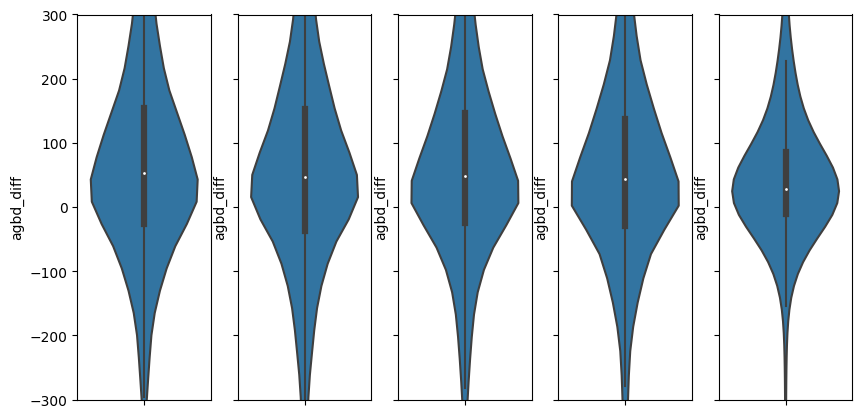

In [327]:
fig, ax = plt.subplots(1, 5, figsize=(10, 5), sharey=True)
sns.violinplot(get_severity(months_3_perfect_matches, 2), y='agbd_diff', ax=ax[0])
sns.violinplot(get_severity(months_6_perfect_matches, 2), y='agbd_diff', ax=ax[1])
sns.violinplot(get_severity(months_12_perfect_matches, 2), y='agbd_diff', ax=ax[2])
sns.violinplot(get_severity(months_24_perfect_matches, 2), y='agbd_diff', ax=ax[3])
sns.violinplot(get_severity(months_24_post_perfect_matches, 2), y='agbd_diff', ax=ax[4])
ax[0].set_ylim((-300, 300))

(-300.0, 300.0)

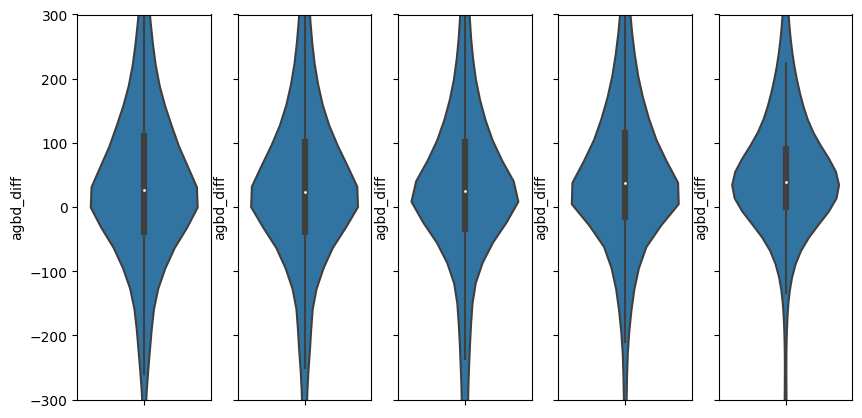

In [328]:
fig, ax = plt.subplots(1, 5, figsize=(10, 5), sharey=True)
sns.violinplot(get_severity(months_3_perfect_matches, 3), y='agbd_diff', ax=ax[0])
sns.violinplot(get_severity(months_6_perfect_matches, 3), y='agbd_diff', ax=ax[1])
sns.violinplot(get_severity(months_12_perfect_matches, 3), y='agbd_diff', ax=ax[2])
sns.violinplot(get_severity(months_24_perfect_matches, 3), y='agbd_diff', ax=ax[3])
sns.violinplot(get_severity(months_24_post_perfect_matches, 3), y='agbd_diff', ax=ax[4])
ax[0].set_ylim((-300, 300))

(-300.0, 300.0)

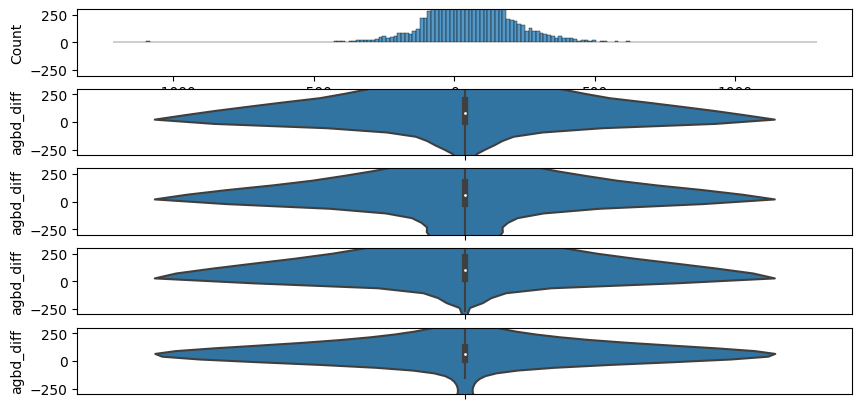

In [331]:
fig, ax = plt.subplots(1, 5, figsize=(10, 5), sharey=True)
sns.violinplot(get_severity(months_3_perfect_matches, 4), y='agbd_diff', ax=ax[0])
sns.violinplot(get_severity(months_6_perfect_matches, 4), y='agbd_diff', ax=ax[1])
sns.violinplot(get_severity(months_12_perfect_matches, 4), y='agbd_diff', ax=ax[2])
sns.violinplot(get_severity(months_24_perfect_matches, 4), y='agbd_diff', ax=ax[3])
sns.violinplot(get_severity(months_24_post_perfect_matches, 4), y='agbd_diff', ax=ax[4])
ax[0].set_ylim((-300, 300))

(-300.0, 300.0)

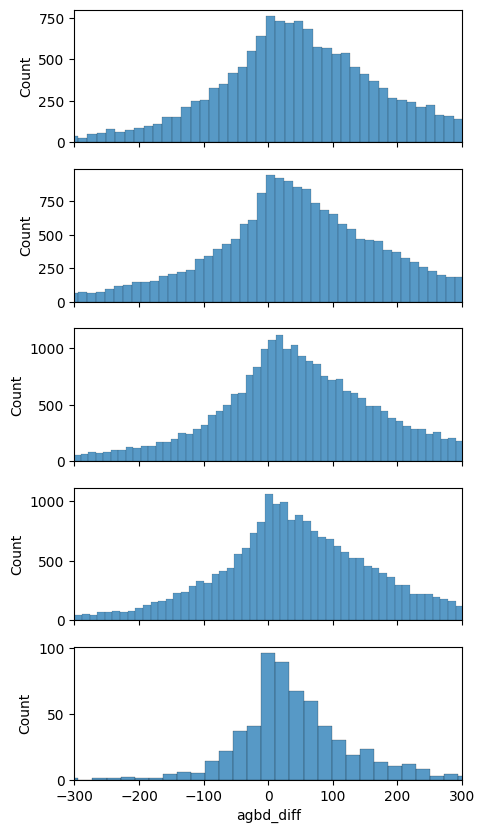

In [335]:
fig, ax = plt.subplots(5, 1, figsize=(5, 10), sharex=True)
sns.histplot(get_severity(months_3_perfect_matches, 2), x='agbd_diff', ax=ax[0])
sns.histplot(get_severity(months_6_perfect_matches, 2), x='agbd_diff', ax=ax[1])
sns.histplot(get_severity(months_12_perfect_matches, 2), x='agbd_diff', ax=ax[2])
sns.histplot(get_severity(months_24_perfect_matches, 2), x='agbd_diff', ax=ax[3])
sns.histplot(get_severity(months_24_post_perfect_matches, 2), x='agbd_diff', ax=ax[4])
ax[0].set_xlim((-300, 300))

(-300.0, 300.0)

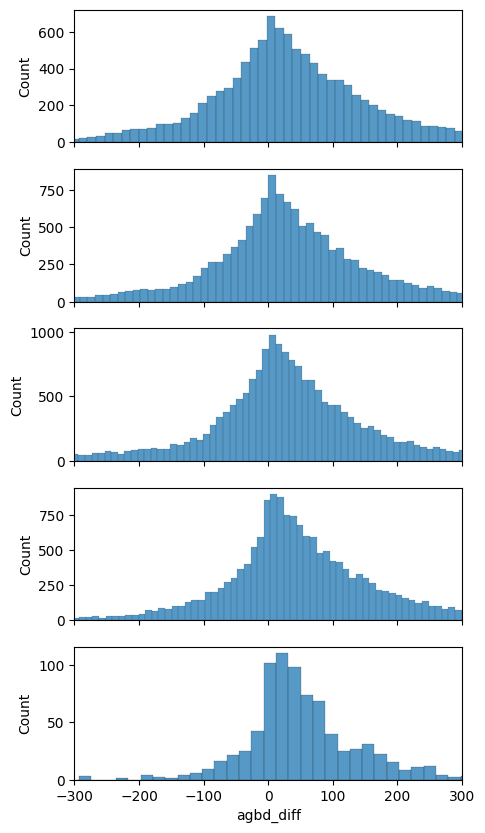

In [336]:
fig, ax = plt.subplots(5, 1, figsize=(5, 10), sharex=True)
sns.histplot(get_severity(months_3_perfect_matches, 3), x='agbd_diff', ax=ax[0])
sns.histplot(get_severity(months_6_perfect_matches, 3), x='agbd_diff', ax=ax[1])
sns.histplot(get_severity(months_12_perfect_matches, 3), x='agbd_diff', ax=ax[2])
sns.histplot(get_severity(months_24_perfect_matches, 3), x='agbd_diff', ax=ax[3])
sns.histplot(get_severity(months_24_post_perfect_matches, 3), x='agbd_diff', ax=ax[4])
ax[0].set_xlim((-300, 300))

(-300.0, 300.0)

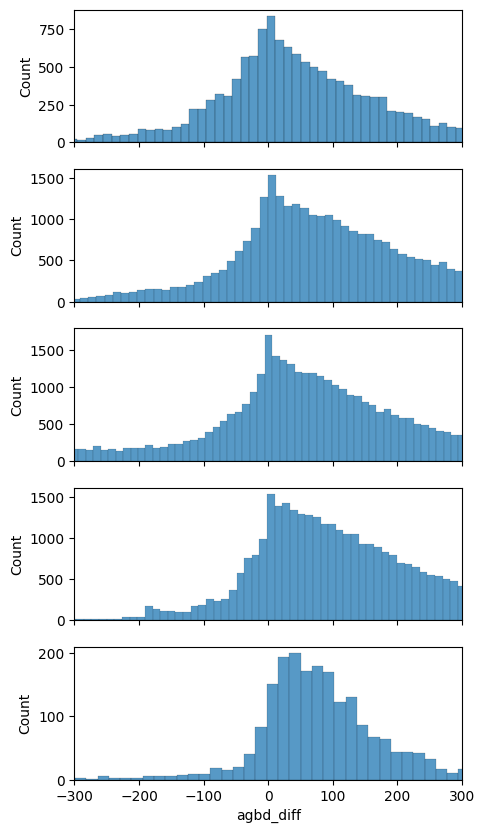

In [334]:
fig, ax = plt.subplots(5, 1, figsize=(5, 10), sharex=True)
sns.histplot(get_severity(months_3_perfect_matches, 4), x='agbd_diff', ax=ax[0])
sns.histplot(get_severity(months_6_perfect_matches, 4), x='agbd_diff', ax=ax[1])
sns.histplot(get_severity(months_12_perfect_matches, 4), x='agbd_diff', ax=ax[2])
sns.histplot(get_severity(months_24_perfect_matches, 4), x='agbd_diff', ax=ax[3])
sns.histplot(get_severity(months_24_post_perfect_matches, 4), x='agbd_diff', ax=ax[4])
ax[0].set_xlim((-300, 300))

In [297]:
fire = Fire(firep[firep.FIRE_NAME == 'CREEK'])

In [303]:
gedi_burned[(gedi_burned.absolute_time > fire.cont_date) & (gedi_burned.absolute_time < fire.cont_date + pd.DateOffset(months=3))]

shot_number                    absolute_time  lon_lowestmode  \
56635     124810100200120578 2021-02-24 12:17:56.082340+00:00     -120.700449   
56644     124810200200125758 2021-02-24 12:17:55.797207+00:00     -120.697112   
56645     124810200200125761 2021-02-24 12:17:55.821999+00:00     -120.695604   
56646     124810200200125762 2021-02-24 12:17:55.830263+00:00     -120.695101   
56647     124810200200125763 2021-02-24 12:17:55.838527+00:00     -120.694602   
...                      ...                              ...             ...   
27618923  116881100200081480 2021-01-04 08:29:36.622878+00:00     -119.548760   
27618924  116881100200081482 2021-01-04 08:29:36.639406+00:00     -119.547751   
27618925  116881100200081483 2021-01-04 08:29:36.647671+00:00     -119.547247   
27618927  116881100200081486 2021-01-04 08:29:36.672469+00:00     -119.545734   
27624178  117490600200451059 2021-01-08 06:55:39.735205+00:00     -119.400916   

          lat_lowestmode        agbd  agbd_pi_lower  agbd_pi_upper    agbd_se  \
56635          38.266862  101.398010      21.042227     241.868912  11.099240   
56644          38.262509   67.711685       7.539475     188.008286  11.100954   
56645          38.263501   45.589119       1.609308     149.703995  11.102924   
56646          38.263832  130.569275      35.334187     285.918549  11.099069   
56647          38.264161   94.693626      18.046879     231.464844  11.100967   
...                  ...         ...            ...            ...        ...   
27618923       38.560574   25.414064   -9999.000000     110.787758  11.106787   
27618924       38.561229   21.686926   -9999.000000     102.855797  11.108901   
27618925       38.561557   27.053759   -9999.000000     114.188141  11.107686   
27618927       38.562538   23.114227   -9999.000000     105.932762  11.107998   
27624178       38.528108   17.447872   -9999.000000      93.369461  11.112385   

          l2_quality_flag  l4_quality_flag  ...  burn_counts_mean  \
56635                   1                1  ...               1.0   
56644                   1                1  ...               1.0   
56645                   1                1  ...               1.0   
56646                   1                1  ...               1.0   
56647                   1                1  ...               1.0   
...                   ...              ...  ...               ...   
27618923                1                1  ...               1.0   
27618924                1                1  ...               1.0   
27618925                1                1  ...               1.0   
27618927                1                1  ...               1.0   
27624178                1                1  ...               1.0   

         burn_counts_std  burn_counts_median  land_cover_2x2 land_cover_mean  \
56635                0.0                 1.0       [1 1 1 1]             1.0   
56644                0.0                 1.0       [5 1 1 1]             2.0   
56645                0.0                 1.0       [1 1 1 1]             1.0   
56646                0.0                 1.0       [1 1 1 1]             1.0   
56647                0.0                 1.0       [1 1 1 1]             1.0   
...                  ...                 ...             ...             ...   
27618923             0.0                 1.0       [1 1 1 1]             1.0   
27618924             0.0                 1.0       [1 1 1 1]             1.0   
27618925             0.0                 1.0       [1 1 1 1]             1.0   
27618927             0.0                 1.0       [5 5 1 5]             4.0   
27624178             0.0                 1.0       [5 5 5 5]             5.0   

         land_cover_std  land_cover_median  gedi_year  gedi_month  \
56635          0.000000                1.0       2021           2   
56644          1.732051                1.0       2021           2   
56645          0.000000                1.0       2021           2   
56646

In [310]:
fire.cont_date + pd.DateOffset(months=12)

Timestamp('2022-07-22 00:00:00+0000', tz='UTC')

In [311]:
fire.cont_date

Timestamp('2021-07-22 00:00:00+0000', tz='UTC')